# Setup Code

In [1]:
# some setup code
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.nn import init
from torch.autograd import Variable
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import itertools

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import layers
import solvers

import params
from config import *

import utils

%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

utils.print_info()

img_size = params.img_size
img_channel = params.img_channel


0.4.0
using device: cuda
data type: torch.float32
VERBOSE== False


# Data Loading

In [83]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples
    
img_transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0, 0, 0), (1, 1, 1))
])

NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST= 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./datasets/MNIST_data', train=True, download=False,
                           transform=img_transform)
loader_train = DataLoader(mnist_train, batch_size=batch_size,
                          sampler=ChunkSampler(NUM_TRAIN, 0))

mnist_val = dset.MNIST('./datasets/MNIST_data', train=True, download=False,
                           transform=img_transform)
loader_val = DataLoader(mnist_val, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

mnist_test = dset.MNIST('./datasets/MNIST_data', train=False, download=False,
                           transform=img_transform)
loader_test = DataLoader(mnist_test, batch_size=batch_size,
                        sampler=ChunkSampler(NUM_TEST,0))

imgs = loader_test.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()


In [34]:
dataloader = utils.dataLoader('SPRITE')

# Network Architecture

In [3]:
def Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn):
    inner_conv_channel = conv_channel//2
    if img_size%4 != 0:
        print("WARNING: image size mod 4 != 0, may produce bug.")
    # total input number of the input of the last conv layer, new image size = old / 2 / 2 
    flatten_img_size = inner_conv_channel * img_size/4 * img_size/4
    
    # explain: first two layer's padding = 2, because we set W/S = W/S + floor((-F+2P)/S+1), S=2,F=5,so P=2
    if VERBOSE:
        print(img_size, in_channel, conv_channel, filter_size, latent_dim, bn)
    model = nn.Sequential(
        layers.ConvLayer(in_channel,        conv_channel,       filter_size, stride=2, padding = 2, bn=bn),
        layers.ConvLayer(conv_channel,      inner_conv_channel, filter_size, stride=2, padding = 2, bn=bn),
        layers.ConvLayer(inner_conv_channel,inner_conv_channel, filter_size, stride=1, padding = 2, bn=bn),
        layers.Flatten(),
        layers.Dense(flatten_img_size, dense_size),
        layers.Dense(dense_size,       latent_dim)
    )
    return model
def Classifier(input_dim, dense_size, s_classes, bn):
    
    model = nn.Sequential(
        layers.Dense(input_dim,  dense_size, bn=bn),
        layers.Dense(dense_size, dense_size, bn=bn),
        layers.Dense(dense_size, s_classes,  bn=bn)
    )
    return model
def Decoder(s_dim, z_dim, img_size, img_channel, conv_channel, filter_size, dense_size, bn):
    # TODO
    # essentially the mirror version of Encoder
    inner_conv_channel = conv_channel//2
    back_img_size = img_size//4
    flatten_img_size = inner_conv_channel * back_img_size * back_img_size
    
    input_dim = s_dim + z_dim
    
    pad = int(np.floor(filter_size/2)) # chose pad this way to fullfill floor((-F+2P)/1+1)==0
    
    model = nn.Sequential(
        layers.Dense(input_dim, dense_size),
        layers.Dense(dense_size, inner_conv_channel*back_img_size*back_img_size),
        layers.Reshape((-1, inner_conv_channel, back_img_size, back_img_size)),
        layers.ConvLayer(inner_conv_channel,    inner_conv_channel, filter_size, stride=1, padding=pad, bn=bn, upsampling=True),
        layers.ConvLayer(inner_conv_channel,    conv_channel, filter_size, stride=1, padding=pad, bn=bn, upsampling=True),
        layers.ConvLayer(conv_channel,    img_channel,       filter_size, stride=1, padding=pad, bn=bn, upsampling=False),
    )
    return model
def AdvLayer(input_dim, dense_size, s_classes, bn):
    # same structure as Classifier
    return Classifier(input_dim, dense_size, s_classes, bn)

In [2]:
def S_Encoder():
    conv_channel= params.enc_conv_channel
    filter_size = params.enc_conv_filter_size
    in_channel  = img_channel
    dense_size  = params.encdec_dense_size
    bn = params.s_enc_bn
    latent_dim = params.s_enc_dim
    
    model = Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn)
    model.m_name='s_encoder'
    return model
def Z_Encoder():
    conv_channel= params.enc_conv_channel
    filter_size = params.enc_conv_filter_size
    in_channel  = img_channel
    dense_size  = params.encdec_dense_size
    bn = params.z_enc_bn
    latent_dim = params.z_enc_dim
    
    model = Encoder(img_size, in_channel, conv_channel, filter_size, latent_dim, dense_size, bn)
    model.m_name='z_encoder'
    return model
def S_Classifier():
    input_dim   = params.s_enc_dim
    dense_size  = params.classifier_dense_size
    classes_num = params.classes_num
    bn          = params.classifier_use_bn
    
    model = Classifier(input_dim, dense_size, classes_num, bn)
    model.m_name='s_classifier'
    return model
def Z_AdvLayer():
    input_dim   = params.z_enc_dim
    dense_size  = params.classifier_dense_size
    classes_num = params.classes_num
    bn          = params.classifier_use_bn
    
    model = AdvLayer(input_dim, dense_size, classes_num, bn)
    return model
def SZ_Decoder():
    s_dim = params.s_enc_dim
    z_dim = params.z_enc_dim
    conv_channel = params.dec_conv_channel
    filter_size  = params.dec_conv_filter_size
    dense_size  = params.encdec_dense_size
    bn           = params.dec_use_bn
    model = Decoder(s_dim, z_dim, img_size, img_channel, conv_channel, filter_size, dense_size, bn)
    model.m_name='sz_decoder'
    return model

def test_Encoder(model):
    x = torch.zeros((64, img_channel, img_size, img_size), dtype=dtype)
    scores = model(x)
    print(scores.size())  # you should see [64, latent_dim]
    print()
def test_classifier(model):
    x = torch.zeros((64, params.s_enc_dim), dtype=dtype)
    scores = model(x)
    print(scores.size())  # should see [64,classes_num]
    print()
def test_Decoder(model):
    x = torch.zeros((64, params.s_enc_dim + params.z_enc_dim), dtype=dtype)
    scores = model(x)
    print(scores.size())  # should see [64,classes_num]
    print()

s_enc_bn = params.s_enc_bn
#test S encoder
test_Encoder(S_Encoder())
#test z encoder
test_Encoder(Z_Encoder())
#test s classifier
test_classifier(S_Classifier())
#test decoder
test_Decoder(SZ_Decoder())

NameError: name 'Encoder' is not defined

# Step1: train s encoder and classifier
the encoder+classifier structure has achieved 97% accuracy on MNIST

In [45]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [31]:
def train_classifier(model, optimizer, epochs=1):
    """
    Train Enc-Classifier on MNIST .
    
    Inputs:
    - model: the enc-classifier 
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print_every = 100
    model = model.to(device=device) # move the model parameters to device
    for epoch in range(epochs):
        for it, (x,y) in enumerate(dataloader.loader_train):
            model.train()
            x = x.to(device = device, dtype=dtype)
            y = y.to(device = device, dtype=torch.long) # QUESTION!!
            
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            if it % print_every == 0:
                print('iteration %d, loss = %.4f' % (it,loss.item()))
                check_accuracy(loader_val, model)
                print()
            

In [48]:
s_enc = S_Encoder()

classifier_solver = solvers.ClassifierSolver(s_enc, S_Classifier(), dataloader)
classifier_solver.train(20)

iteration 1000, loss = 0.1811
Checking accuracy on validation set
Got 4875 / 5000 correct (97.50)

iteration 2000, loss = 0.0859
Checking accuracy on validation set
Got 4861 / 5000 correct (97.22)

iteration 3000, loss = 0.0288
Checking accuracy on validation set
Got 4921 / 5000 correct (98.42)

iteration 4000, loss = 0.0066
Checking accuracy on validation set
Got 4875 / 5000 correct (97.50)

iteration 5000, loss = 0.0690
Checking accuracy on validation set
Got 4901 / 5000 correct (98.02)

iteration 6000, loss = 0.0020
Checking accuracy on validation set
Got 4919 / 5000 correct (98.38)

iteration 7000, loss = 0.0225
Checking accuracy on validation set
Got 4903 / 5000 correct (98.06)



In [49]:
check_accuracy(dataloader.loader_test, classifier_solver.classifier)

Checking accuracy on test set
Got 4887 / 5000 correct (97.74)


In [52]:
# test accuray and save the model
# check_accuracy(dataloader.loader_test, s_classifier)

#torch.save(s_enc, "./saved_models/S_enc")
#utils.save_models(s_enc)
utils.load_models(s_enc)

## test decoder
you can skip this sub session

In [53]:
def full_test_Decoder(model,optimizer,epochs = 2):
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, _) in enumerate(loader_train):
            model.train()  # put model to training mode
            y = x.clone()
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)

            reconstruction = model(x)
            loss = nn.MSELoss(size_average=False)(reconstruction, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                print()
szdec = SZ_Decoder()
layers.set_trainable(s_enc,True)
layers.set_trainable(s_enc,True)

modelDecTest = layers.DecoderTest(s_enc, szdec)
optimizerDecTest = solvers.get_optimizer(modelDecTest)
layers.set_trainable(s_enc,True)
layers.set_trainable(szdec,True)

full_test_Decoder(modelDecTest,optimizerDecTest,20)

In [54]:
def test_recon(model):
    img=torch.tensor(imgs[0:8])
    imgr=torch.tensor(img.reshape(-1,img_channel,img_size,img_size))
    imgr = imgr.to(device=device,dtype=dtype)
    imgo = model(imgr)
    imgo = imgo.view(-1,28*28).cpu().detach()
    print(img.shape,imgo.shape,torch.cat((img,imgo)).shape)
    utils.show_images(torch.cat((img,imgo)))

## some images in the test set

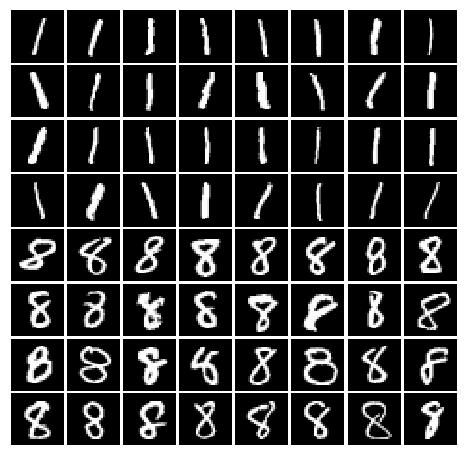

In [92]:
img_stat = [[] for i in range(params.classes_num)]
for it, (xbat,ybat) in enumerate(dataloader.loader_test):
    for i in range(len(ybat)):
        x = xbat[i]
        y = ybat[i]
        img_stat[y.item()].append( x.view(img_size*img_size) )
#print([img_stat[0][i].view(784) for i in range(20)])
showed = [img_stat[1][i] for i in range(32)]
showed += [img_stat[8][i] for i in range(32)]
torch.stack(showed)
utils.show_images(torch.stack(showed))

# Step two, train disentangle-adversariel network

In [115]:
z_enc = Z_Encoder().to(device=device, dtype=dtype); z_enc.m_name = 'z_enc';
z_adv = Z_AdvLayer().to(device=device, dtype=dtype); z_adv.m_name = 'z_adv';
sz_dec= SZ_Decoder().to(device=device, dtype=dtype); sz_dec.m_name = 'sz_dec';
s_enc = s_enc.to(device=device, dtype=dtype); s_enc.m_name = 's_enc';
dis_adv_solver = solvers.DisAdvSolver(s_enc, z_enc, sz_dec, z_adv, dataloader)
save_list = [s_enc, z_enc, sz_dec, z_adv]

Iter: 0, rencon_loss: 0.1943, adv_loss: 2.354, disent_loss:-1.382
adv classifier accuracy:
Checking accuracy on test set
Got 493 / 5000 correct (9.86)
z_latent_norm: tensor(3.3941, device='cuda:0')


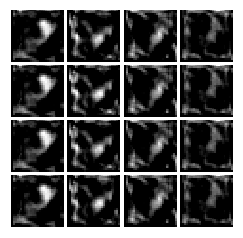

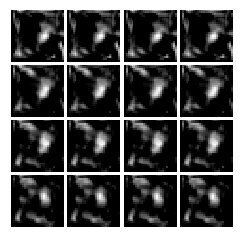

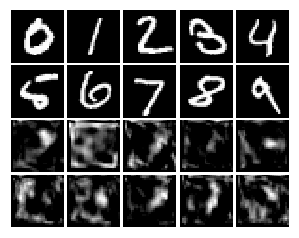


Iter: 3000, rencon_loss: 0.02246, adv_loss: 2.303, disent_loss:-2.19
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(110.7180, device='cuda:0')


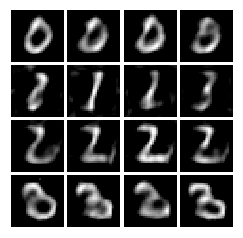

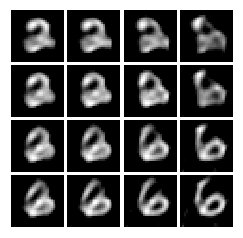

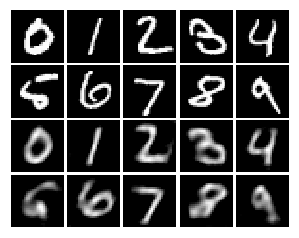


Iter: 6000, rencon_loss: 0.01792, adv_loss: 2.303, disent_loss:-2.213
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(146.1730, device='cuda:0')


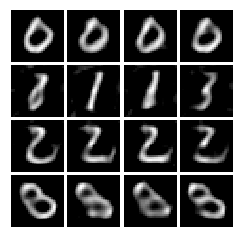

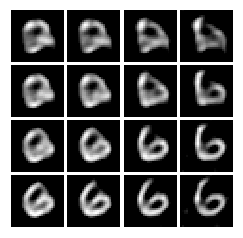

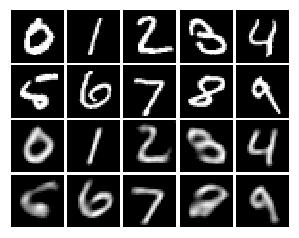


Iter: 9000, rencon_loss: 0.01408, adv_loss: 2.303, disent_loss:-2.232
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(173.3139, device='cuda:0')


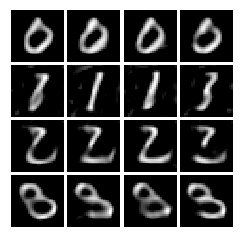

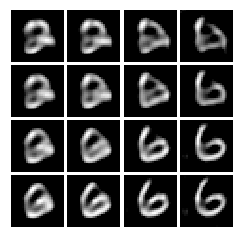

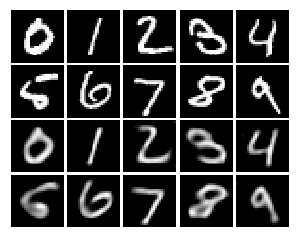


Iter: 12000, rencon_loss: 0.01362, adv_loss: 2.303, disent_loss:-2.234
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(201.9533, device='cuda:0')


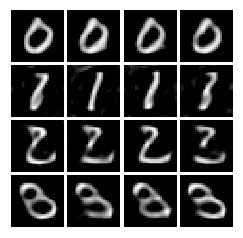

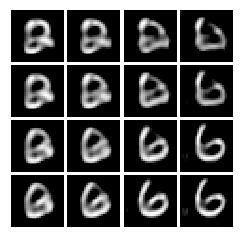

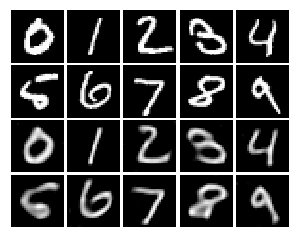


Iter: 15000, rencon_loss: 0.01165, adv_loss: 2.303, disent_loss:-2.244
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(221.5467, device='cuda:0')


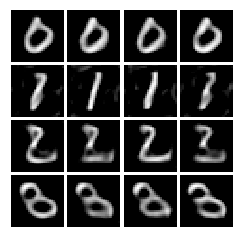

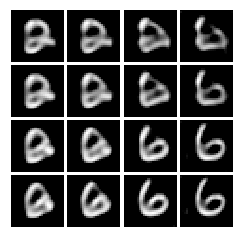

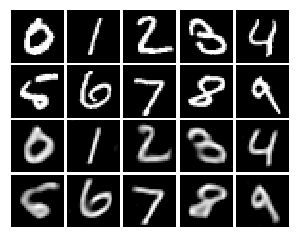


Iter: 18000, rencon_loss: 0.01157, adv_loss: 2.303, disent_loss:-2.245
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(225.9409, device='cuda:0')


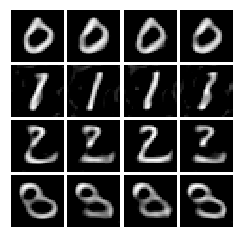

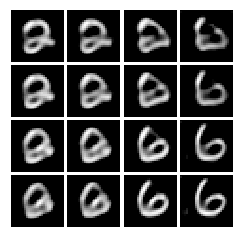

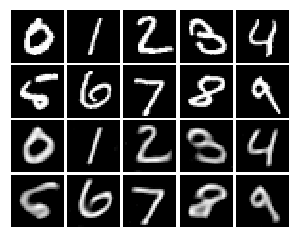


Iter: 21000, rencon_loss: 0.01188, adv_loss: 2.303, disent_loss:-2.243
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(246.7192, device='cuda:0')


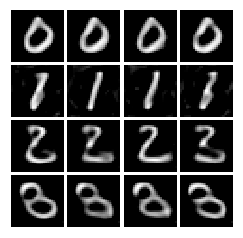

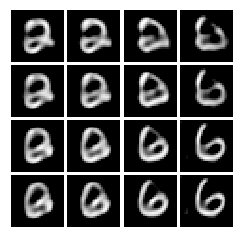

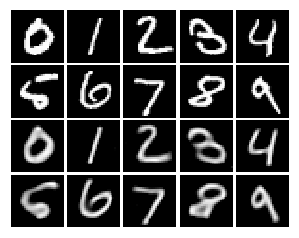


Iter: 24000, rencon_loss: 0.01067, adv_loss: 2.303, disent_loss:-2.249
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(239.8987, device='cuda:0')


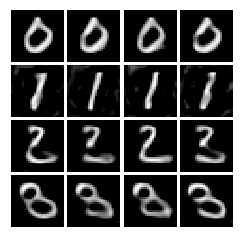

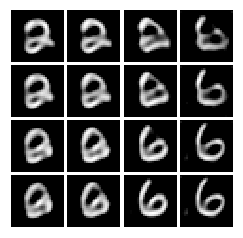

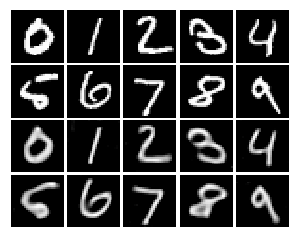


Iter: 27000, rencon_loss: 0.01079, adv_loss: 2.303, disent_loss:-2.249
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(259.3564, device='cuda:0')


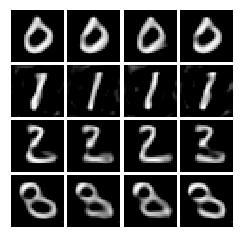

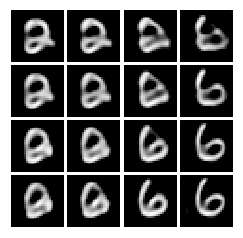

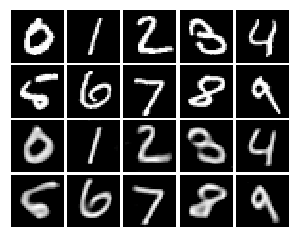


Iter: 30000, rencon_loss: 0.01017, adv_loss: 2.303, disent_loss:-2.252
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(265.8089, device='cuda:0')


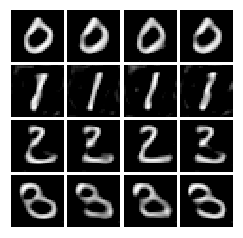

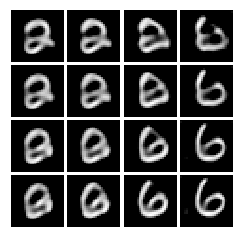

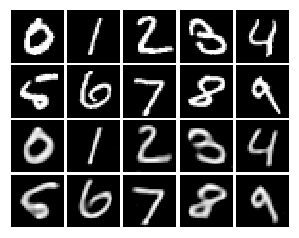


Iter: 33000, rencon_loss: 0.01097, adv_loss: 2.303, disent_loss:-2.248
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(270.4319, device='cuda:0')


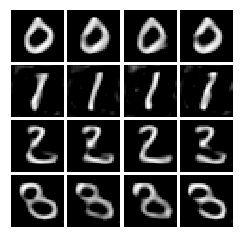

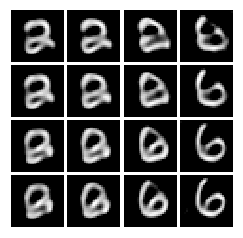

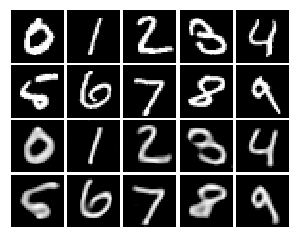


Iter: 36000, rencon_loss: 0.01143, adv_loss: 2.303, disent_loss:-2.245
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(302.9934, device='cuda:0')


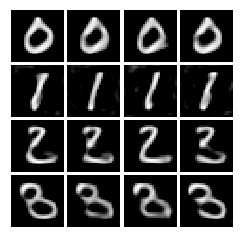

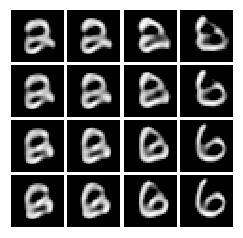

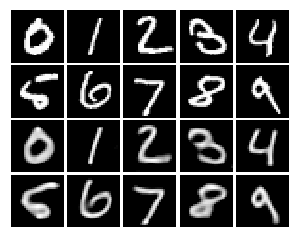


Iter: 39000, rencon_loss: 0.01128, adv_loss: 2.303, disent_loss:-2.246
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(305.5713, device='cuda:0')


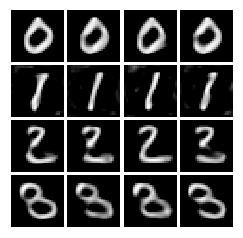

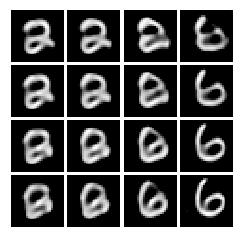

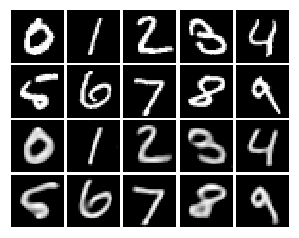


Iter: 42000, rencon_loss: 0.01017, adv_loss: 2.303, disent_loss:-2.252
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(299.2855, device='cuda:0')


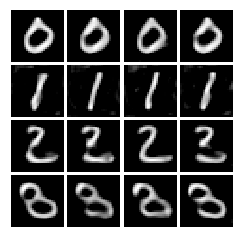

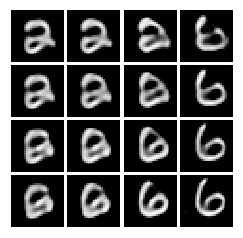

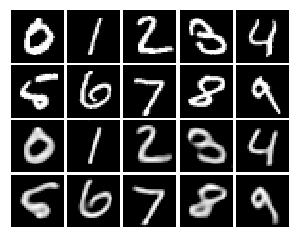


Iter: 45000, rencon_loss: 0.00815, adv_loss: 2.303, disent_loss:-2.262
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(307.3665, device='cuda:0')


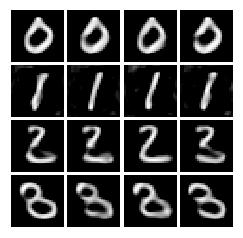

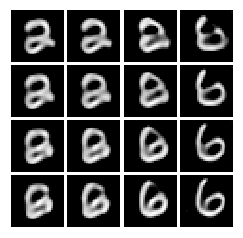

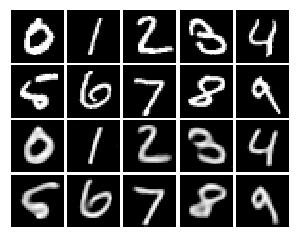


Iter: 48000, rencon_loss: 0.01079, adv_loss: 2.303, disent_loss:-2.249
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(309.8750, device='cuda:0')


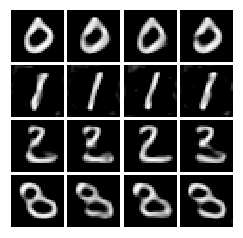

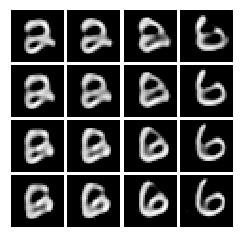

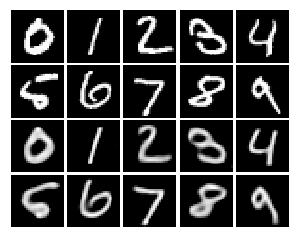


Iter: 51000, rencon_loss: 0.01011, adv_loss: 2.303, disent_loss:-2.252
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(328.5363, device='cuda:0')


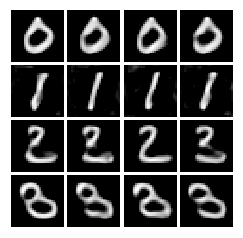

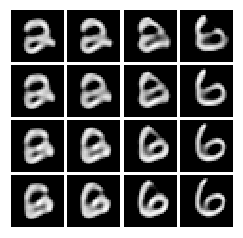

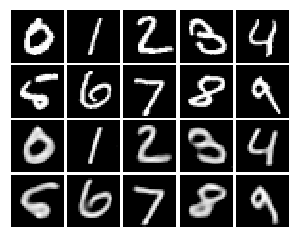


Iter: 54000, rencon_loss: 0.00927, adv_loss: 2.303, disent_loss:-2.256
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(338.8557, device='cuda:0')


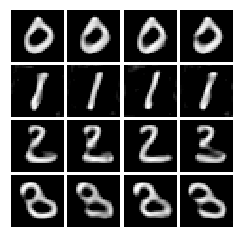

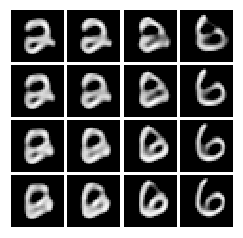

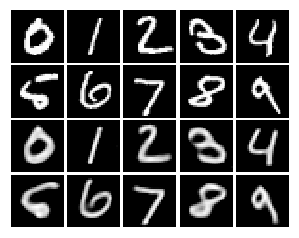


Iter: 57000, rencon_loss: 0.009053, adv_loss: 2.303, disent_loss:-2.257
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(334.8266, device='cuda:0')


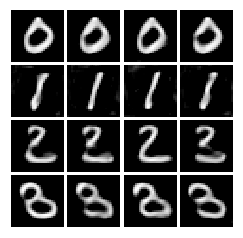

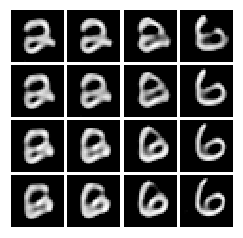

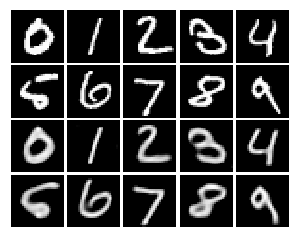


Iter: 60000, rencon_loss: 0.01125, adv_loss: 2.303, disent_loss:-2.246
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(341.0747, device='cuda:0')


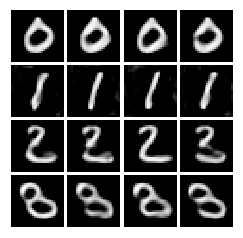

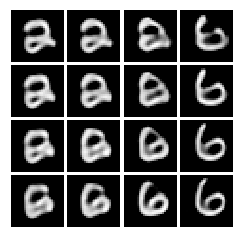

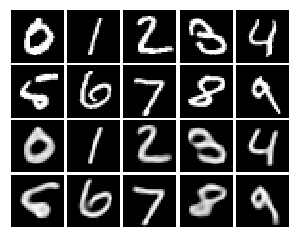


Iter: 63000, rencon_loss: 0.008141, adv_loss: 2.303, disent_loss:-2.262
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(339.5662, device='cuda:0')


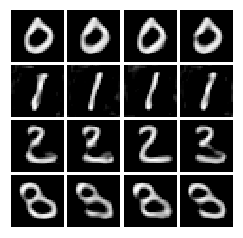

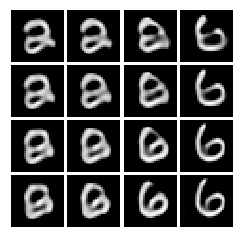

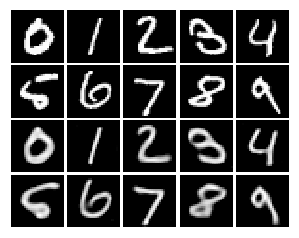


Iter: 66000, rencon_loss: 0.0084, adv_loss: 2.303, disent_loss:-2.261
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(333.4471, device='cuda:0')


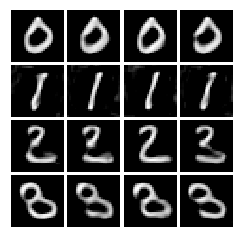

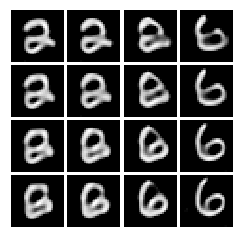

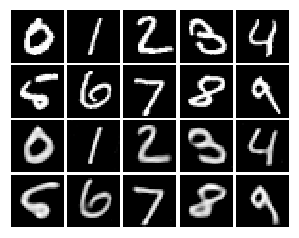


Iter: 69000, rencon_loss: 0.01055, adv_loss: 2.303, disent_loss:-2.25
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(329.1004, device='cuda:0')


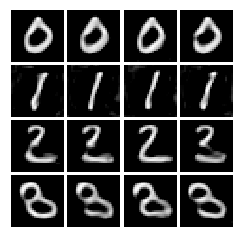

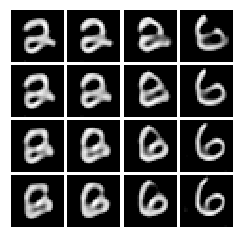

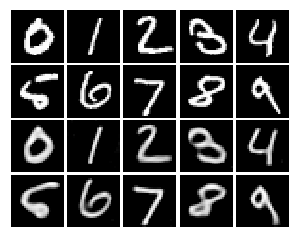


Iter: 72000, rencon_loss: 0.00991, adv_loss: 2.303, disent_loss:-2.253
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(320.8063, device='cuda:0')


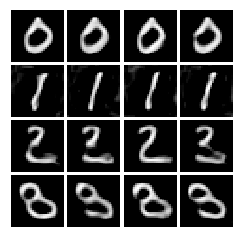

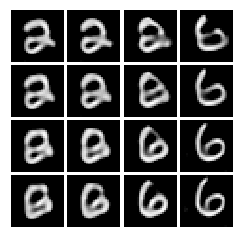

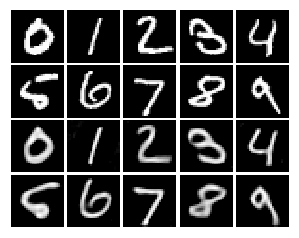


Iter: 75000, rencon_loss: 0.007431, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(346.1036, device='cuda:0')


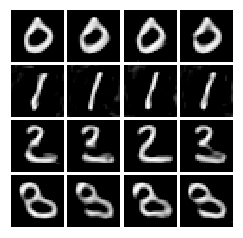

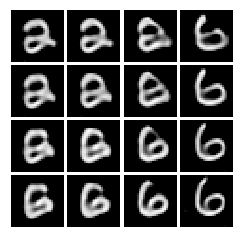

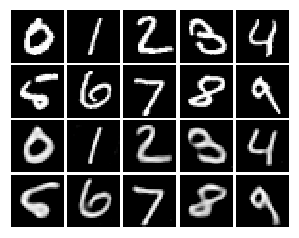


Iter: 78000, rencon_loss: 0.00856, adv_loss: 2.303, disent_loss:-2.26
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(342.9120, device='cuda:0')


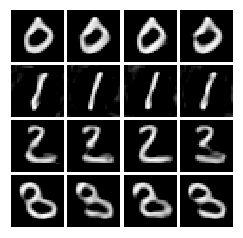

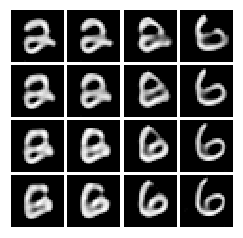

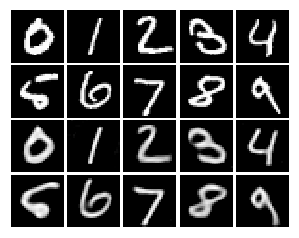


Iter: 81000, rencon_loss: 0.007461, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(354.3681, device='cuda:0')


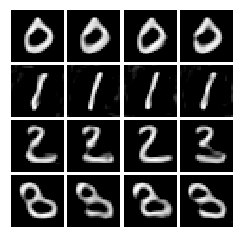

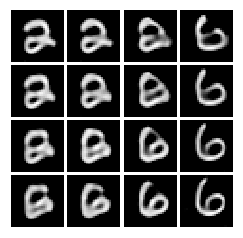

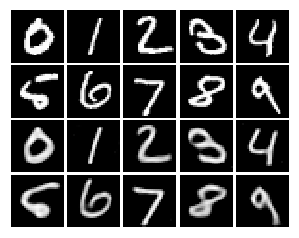


Iter: 84000, rencon_loss: 0.007939, adv_loss: 2.303, disent_loss:-2.263
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(333.0398, device='cuda:0')


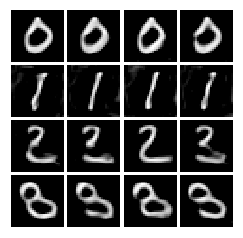

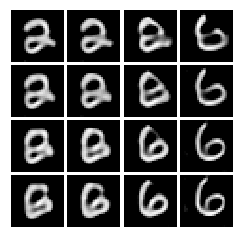

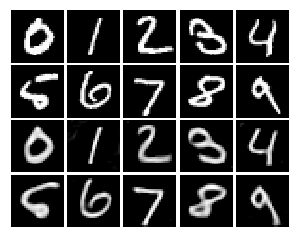


Iter: 87000, rencon_loss: 0.008448, adv_loss: 2.303, disent_loss:-2.26
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(399.1241, device='cuda:0')


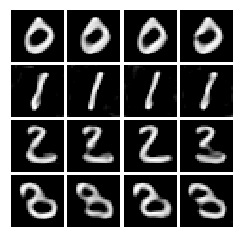

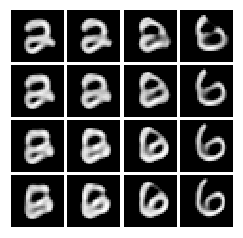

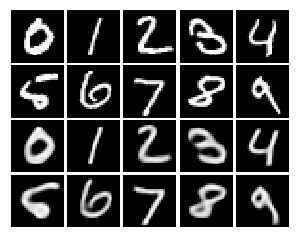


Iter: 90000, rencon_loss: 0.006615, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(364.2240, device='cuda:0')


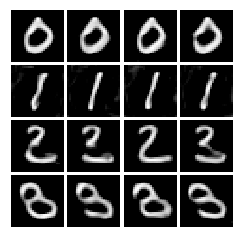

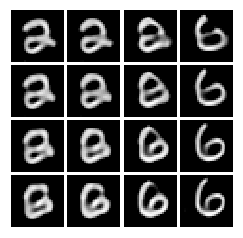

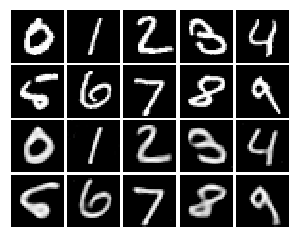


Iter: 93000, rencon_loss: 0.009114, adv_loss: 2.303, disent_loss:-2.257
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(387.5267, device='cuda:0')


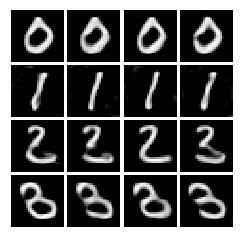

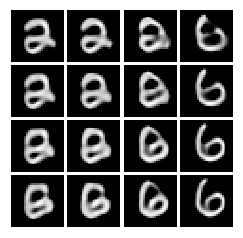

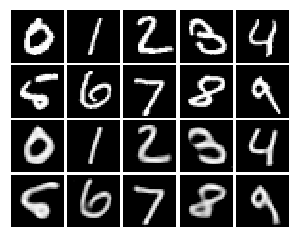


Iter: 96000, rencon_loss: 0.007877, adv_loss: 2.303, disent_loss:-2.263
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(357.8441, device='cuda:0')


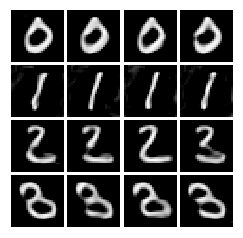

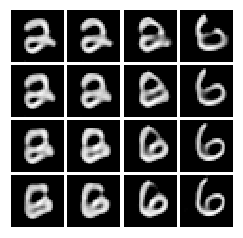

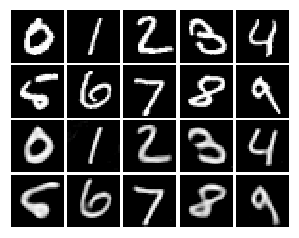


Iter: 99000, rencon_loss: 0.006898, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(358.8661, device='cuda:0')


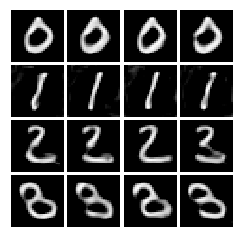

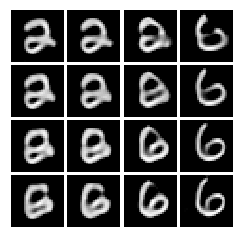

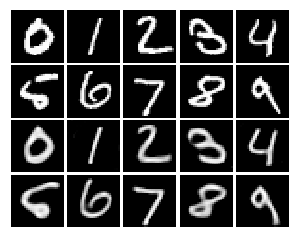


Iter: 102000, rencon_loss: 0.007259, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(379.3385, device='cuda:0')


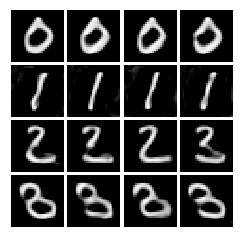

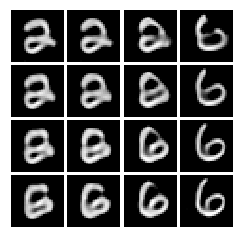

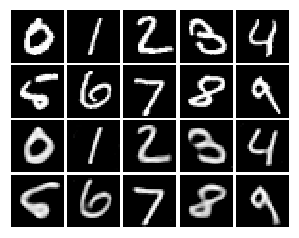


Iter: 105000, rencon_loss: 0.01101, adv_loss: 2.303, disent_loss:-2.248
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(394.2634, device='cuda:0')


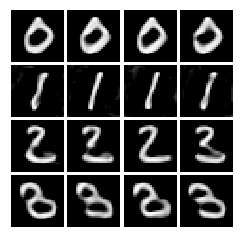

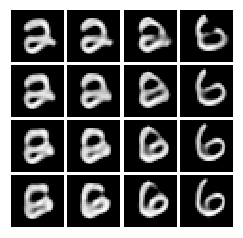

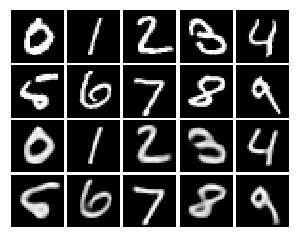


Iter: 108000, rencon_loss: 0.006848, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(389.1545, device='cuda:0')


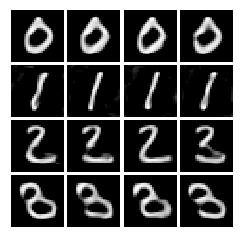

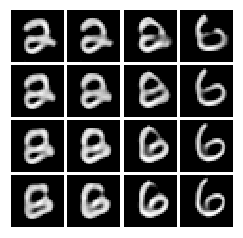

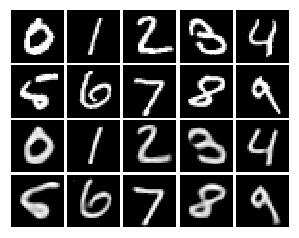


Iter: 111000, rencon_loss: 0.007131, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(378.8804, device='cuda:0')


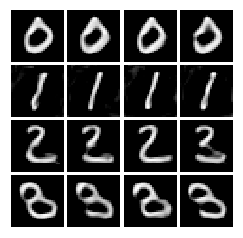

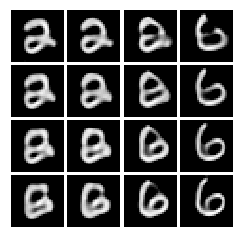

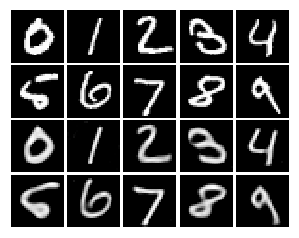


Iter: 114000, rencon_loss: 0.007776, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(408.1641, device='cuda:0')


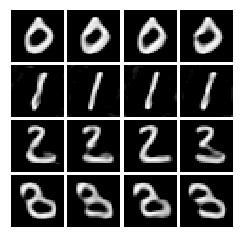

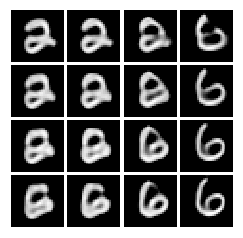

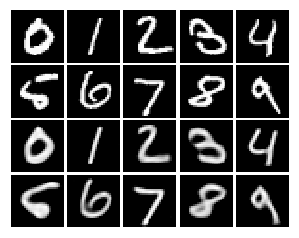


Iter: 117000, rencon_loss: 0.008012, adv_loss: 2.303, disent_loss:-2.263
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(388.8667, device='cuda:0')


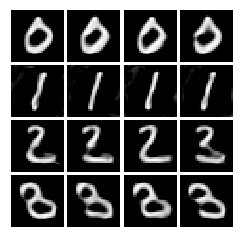

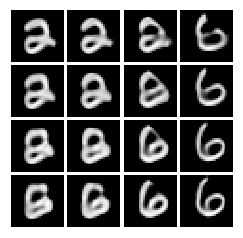

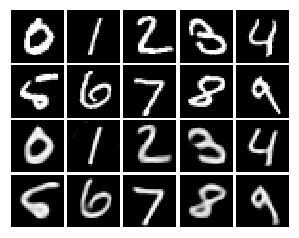


Iter: 120000, rencon_loss: 0.007406, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(398.3961, device='cuda:0')


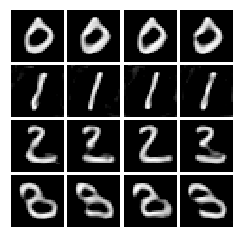

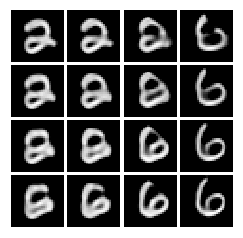

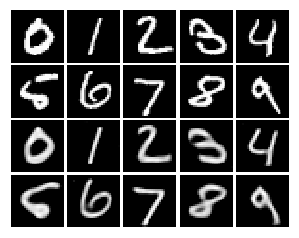


Iter: 123000, rencon_loss: 0.008168, adv_loss: 2.303, disent_loss:-2.262
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(411.3384, device='cuda:0')


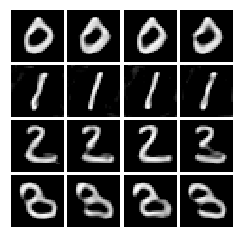

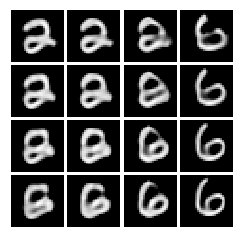

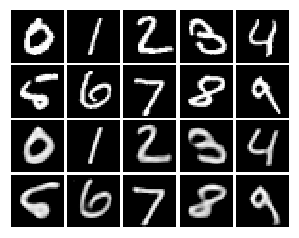


Iter: 126000, rencon_loss: 0.007403, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(418.3598, device='cuda:0')


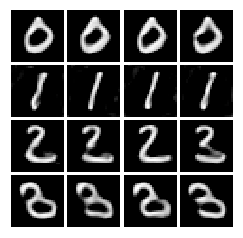

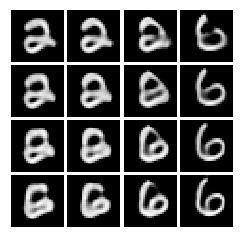

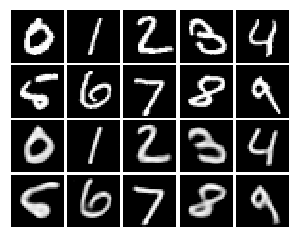


Iter: 129000, rencon_loss: 0.007648, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(412.1735, device='cuda:0')


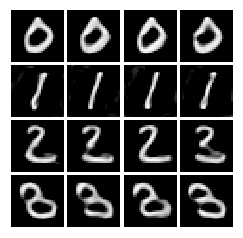

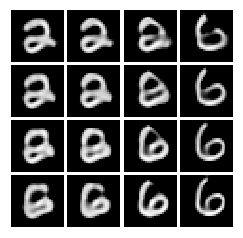

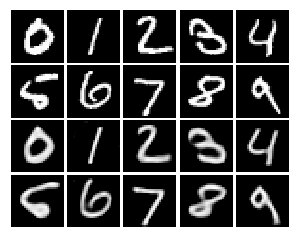


Iter: 132000, rencon_loss: 0.007583, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(396.8264, device='cuda:0')


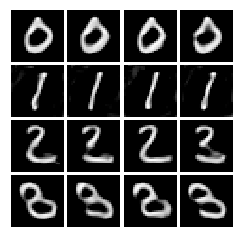

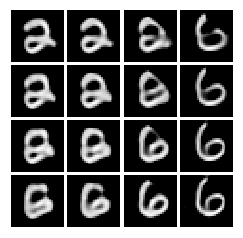

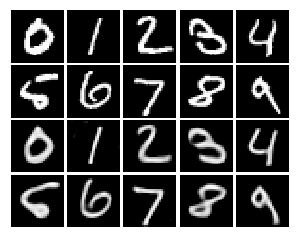


Iter: 135000, rencon_loss: 0.007658, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(418.6261, device='cuda:0')


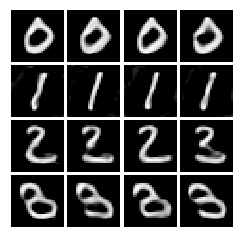

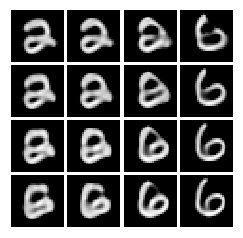

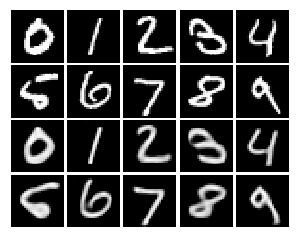


Iter: 138000, rencon_loss: 0.007596, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(403.1685, device='cuda:0')


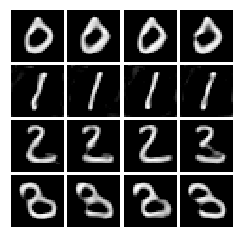

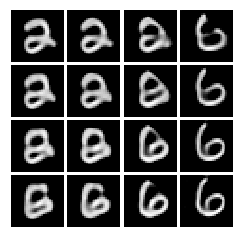

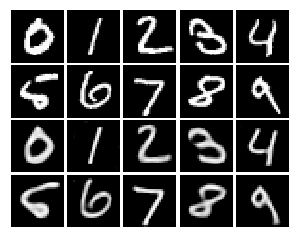


Iter: 141000, rencon_loss: 0.007251, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(418.2455, device='cuda:0')


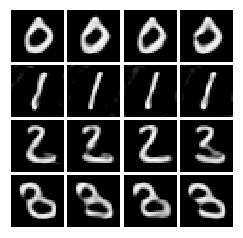

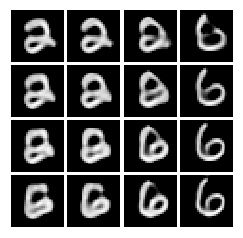

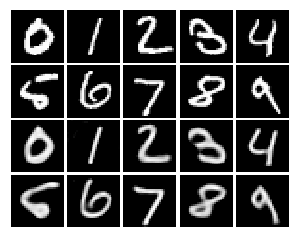


Iter: 144000, rencon_loss: 0.007557, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(411.9273, device='cuda:0')


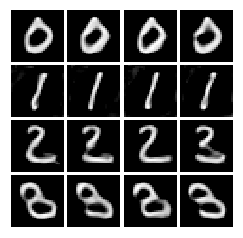

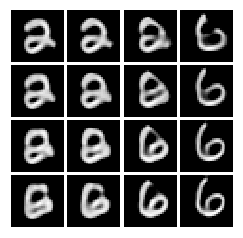

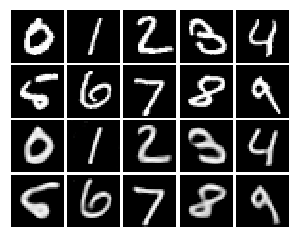


Iter: 147000, rencon_loss: 0.007749, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(439.0176, device='cuda:0')


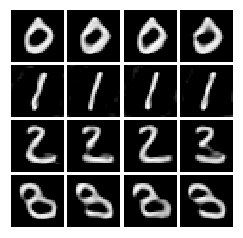

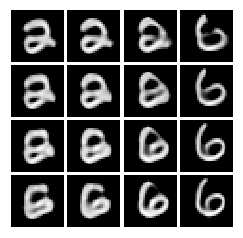

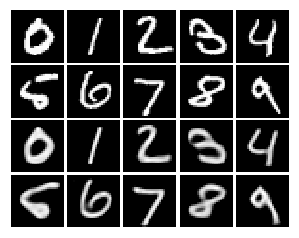


Iter: 150000, rencon_loss: 0.007789, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(415.0976, device='cuda:0')


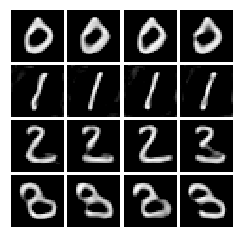

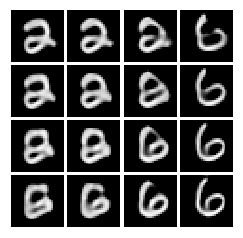

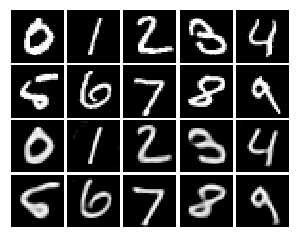


Iter: 153000, rencon_loss: 0.007202, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(420.5597, device='cuda:0')


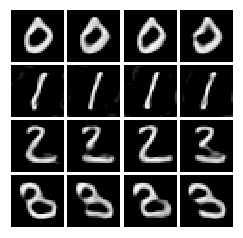

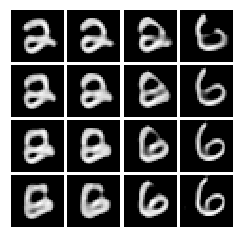

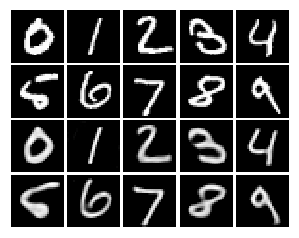


Iter: 156000, rencon_loss: 0.009917, adv_loss: 2.303, disent_loss:-2.253
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(405.1040, device='cuda:0')


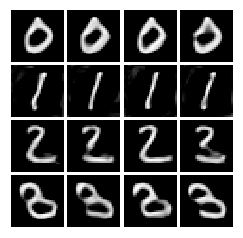

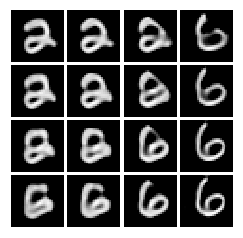

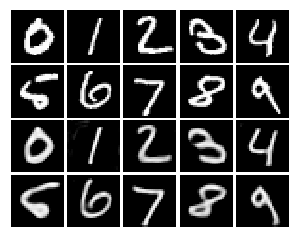


Iter: 159000, rencon_loss: 0.006488, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(418.3409, device='cuda:0')


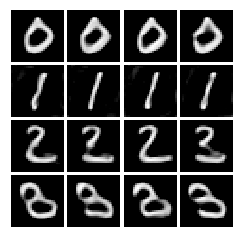

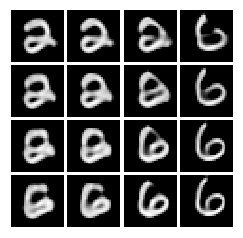

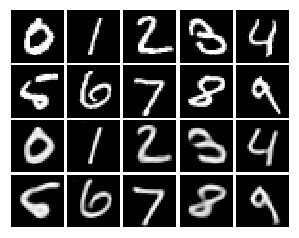


Iter: 162000, rencon_loss: 0.006541, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(444.7027, device='cuda:0')


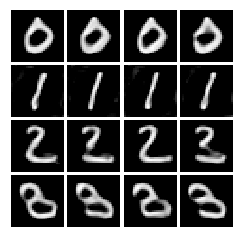

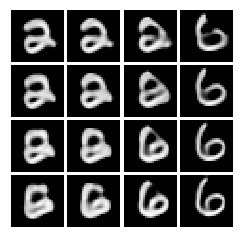

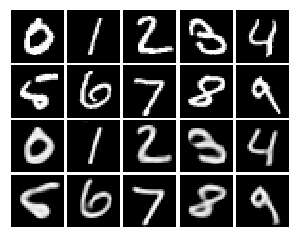


Iter: 165000, rencon_loss: 0.007761, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(438.4670, device='cuda:0')


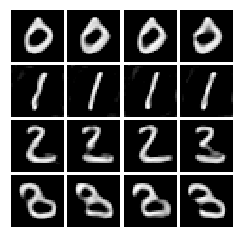

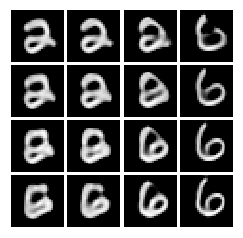

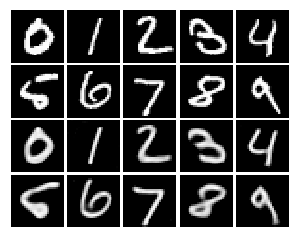


Iter: 168000, rencon_loss: 0.006425, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(432.7729, device='cuda:0')


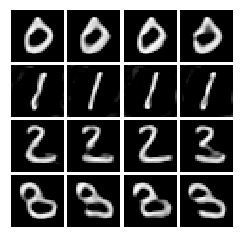

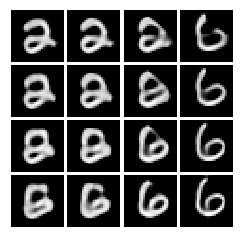

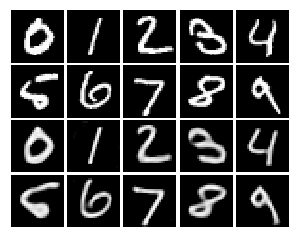


Iter: 171000, rencon_loss: 0.007251, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(449.5022, device='cuda:0')


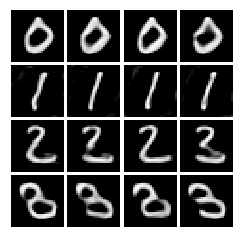

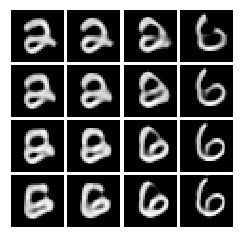

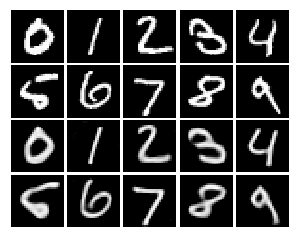


Iter: 174000, rencon_loss: 0.006373, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(443.9068, device='cuda:0')


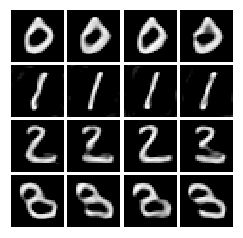

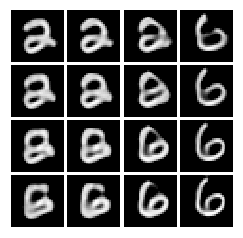

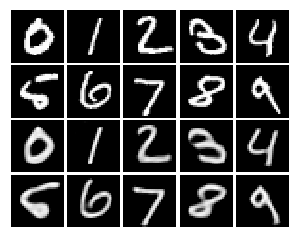


Iter: 177000, rencon_loss: 0.006788, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(448.3862, device='cuda:0')


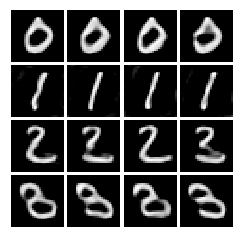

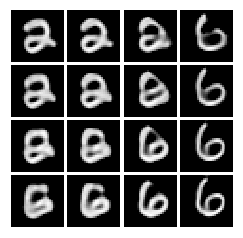

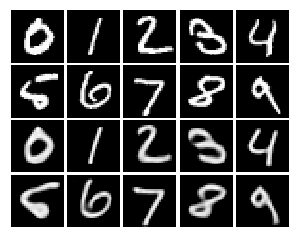


Iter: 180000, rencon_loss: 0.006241, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(464.4897, device='cuda:0')


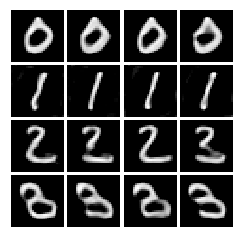

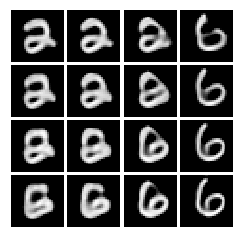

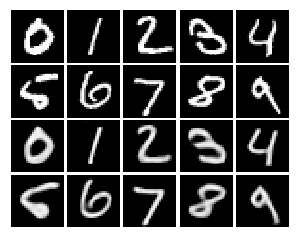


Iter: 183000, rencon_loss: 0.006818, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(447.3109, device='cuda:0')


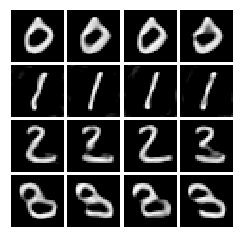

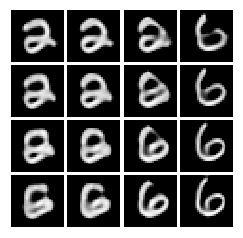

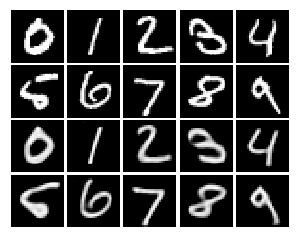


Iter: 186000, rencon_loss: 0.006232, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(441.7401, device='cuda:0')


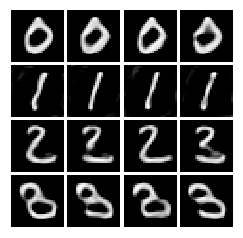

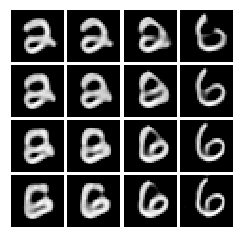

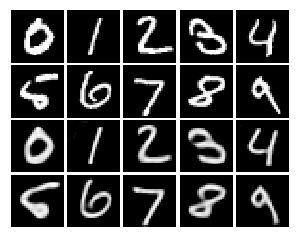


Iter: 189000, rencon_loss: 0.007194, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(445.0545, device='cuda:0')


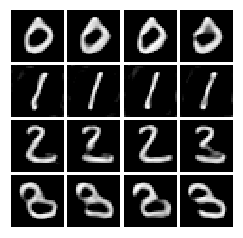

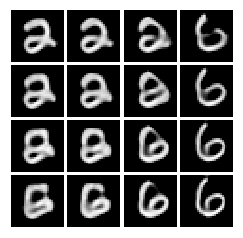

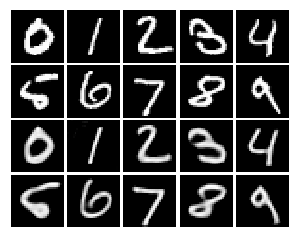


Iter: 192000, rencon_loss: 0.006479, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(467.3364, device='cuda:0')


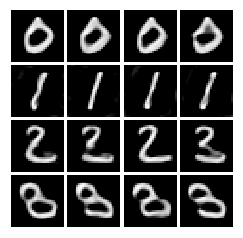

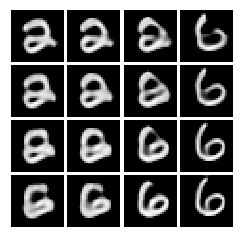

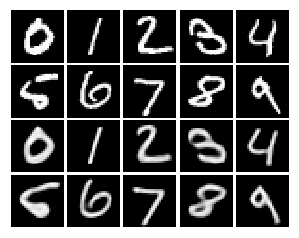


Iter: 195000, rencon_loss: 0.007409, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(494.6455, device='cuda:0')


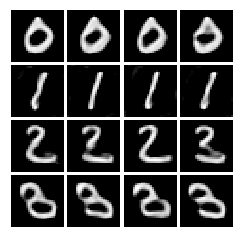

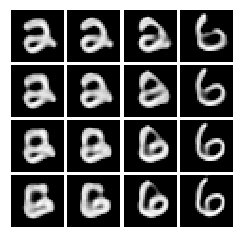

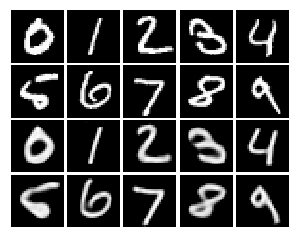


Iter: 198000, rencon_loss: 0.008032, adv_loss: 2.303, disent_loss:-2.262
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(492.8563, device='cuda:0')


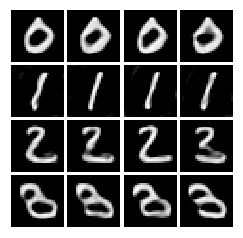

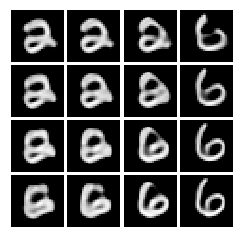

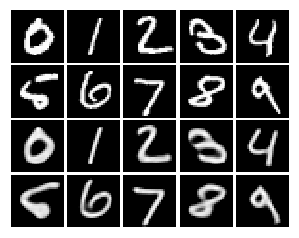


Iter: 201000, rencon_loss: 0.006269, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(473.9644, device='cuda:0')


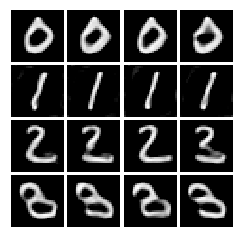

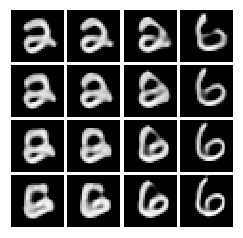

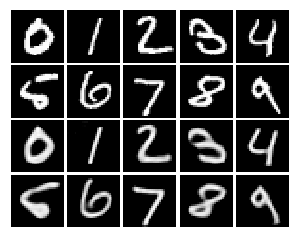


Iter: 204000, rencon_loss: 0.006502, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(482.8961, device='cuda:0')


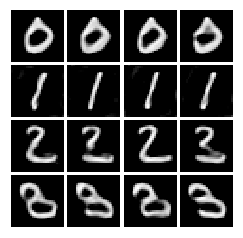

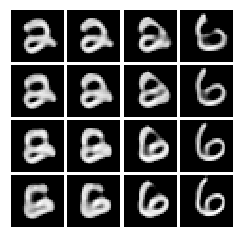

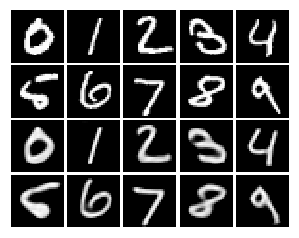


Iter: 207000, rencon_loss: 0.006766, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(466.7251, device='cuda:0')


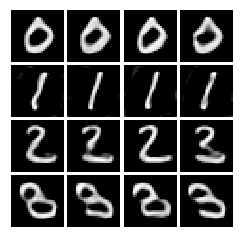

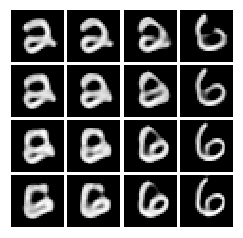

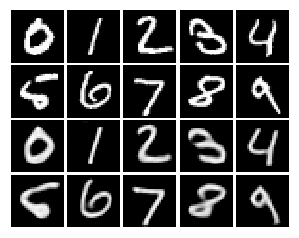


Iter: 210000, rencon_loss: 0.007428, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(473.6337, device='cuda:0')


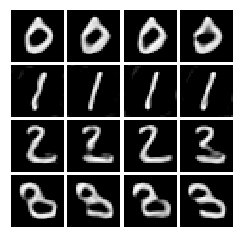

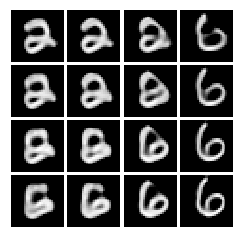

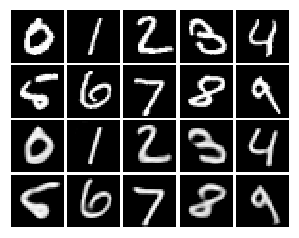


Iter: 213000, rencon_loss: 0.006455, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(469.0621, device='cuda:0')


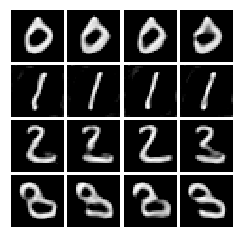

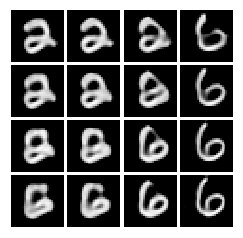

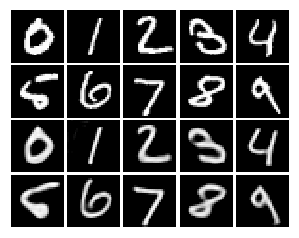


Iter: 216000, rencon_loss: 0.005937, adv_loss: 2.303, disent_loss:-2.273
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(492.5542, device='cuda:0')


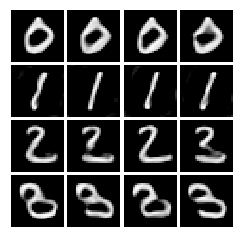

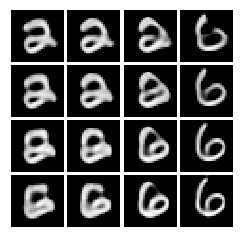

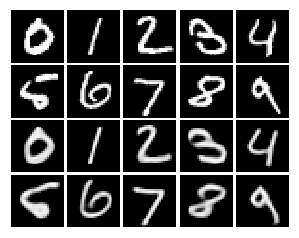


Iter: 219000, rencon_loss: 0.006882, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(470.4168, device='cuda:0')


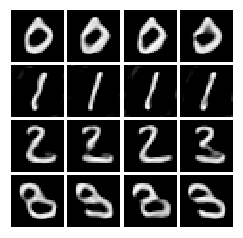

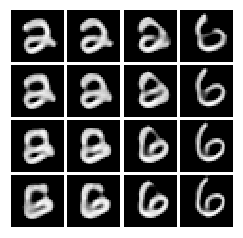

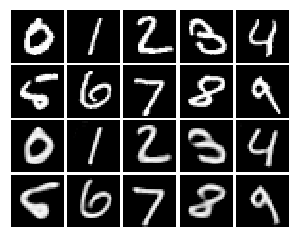


Iter: 222000, rencon_loss: 0.006697, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(501.6653, device='cuda:0')


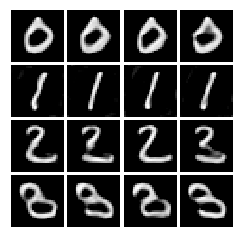

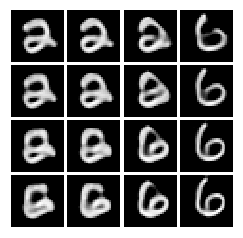

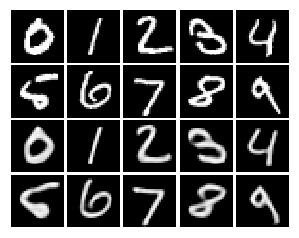


Iter: 225000, rencon_loss: 0.007685, adv_loss: 2.303, disent_loss:-2.264
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(464.3931, device='cuda:0')


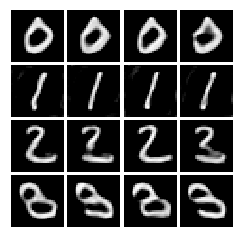

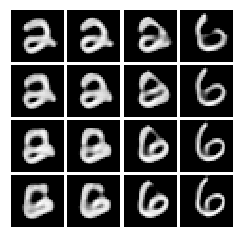

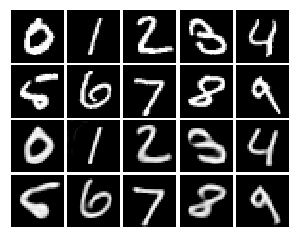


Iter: 228000, rencon_loss: 0.007384, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(515.1370, device='cuda:0')


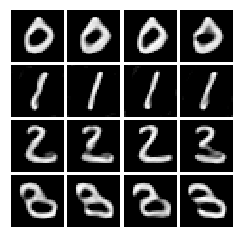

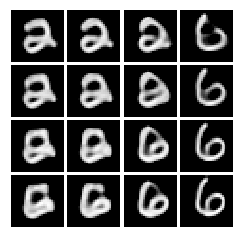

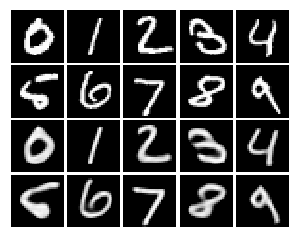


Iter: 231000, rencon_loss: 0.00861, adv_loss: 2.303, disent_loss:-2.26
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(467.6307, device='cuda:0')


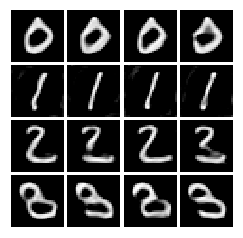

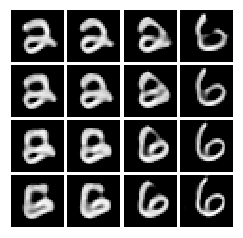

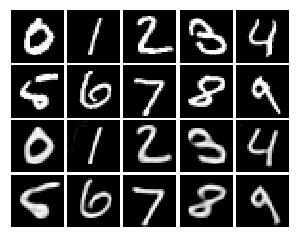


Iter: 234000, rencon_loss: 0.007822, adv_loss: 2.303, disent_loss:-2.263
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(492.0306, device='cuda:0')


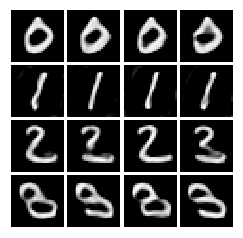

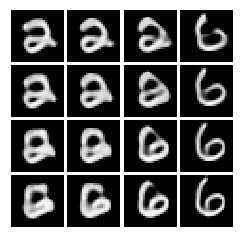

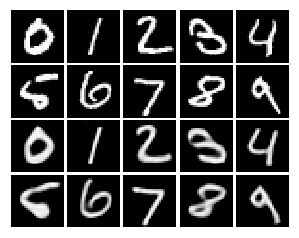


Iter: 237000, rencon_loss: 0.007462, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(503.5233, device='cuda:0')


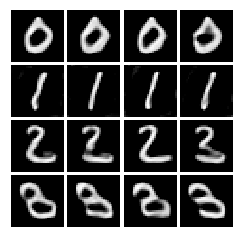

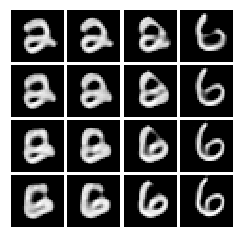

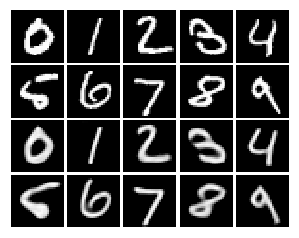


Iter: 240000, rencon_loss: 0.006292, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(503.4409, device='cuda:0')


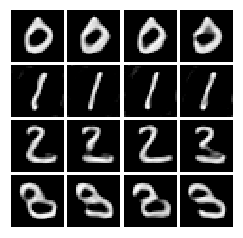

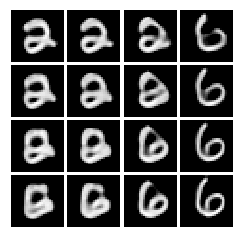

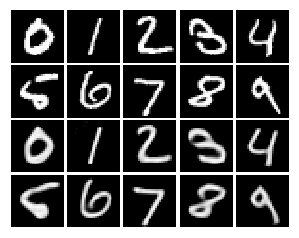


Iter: 243000, rencon_loss: 0.006569, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(504.7904, device='cuda:0')


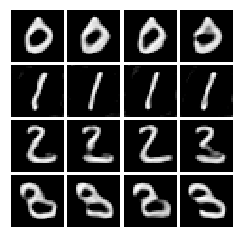

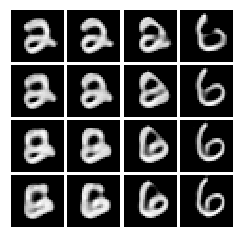

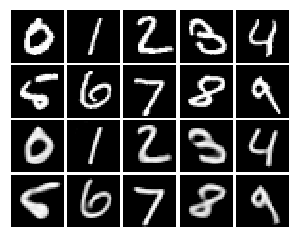


Iter: 246000, rencon_loss: 0.007192, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(505.1159, device='cuda:0')


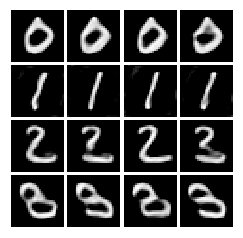

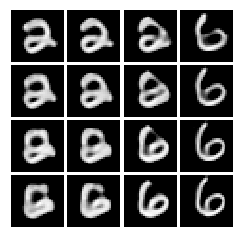

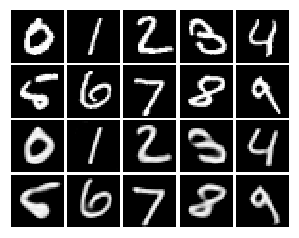


Iter: 249000, rencon_loss: 0.006593, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(482.2550, device='cuda:0')


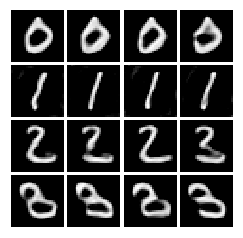

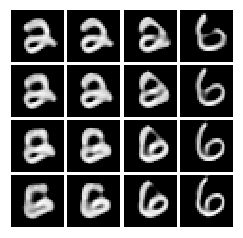

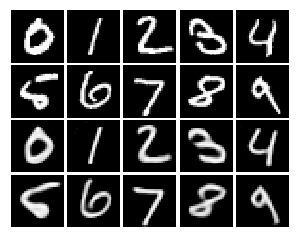


Iter: 252000, rencon_loss: 0.006998, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(483.0222, device='cuda:0')


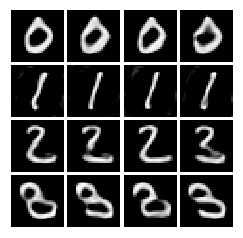

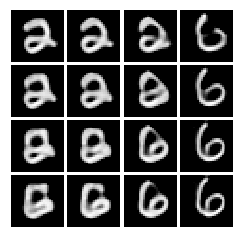

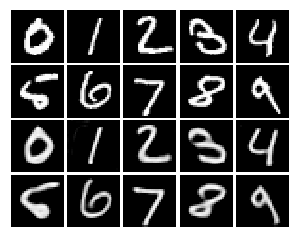


Iter: 255000, rencon_loss: 0.006718, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(518.4158, device='cuda:0')


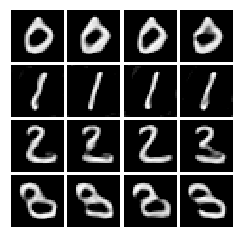

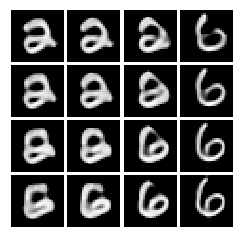

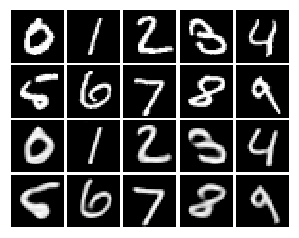


Iter: 258000, rencon_loss: 0.007102, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(505.9145, device='cuda:0')


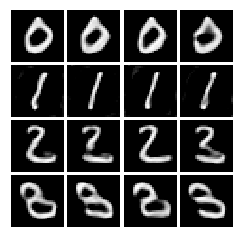

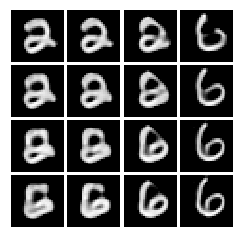

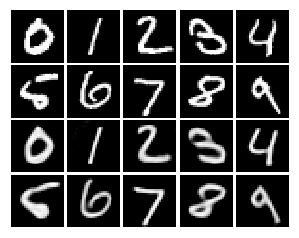


Iter: 261000, rencon_loss: 0.007587, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(521.0541, device='cuda:0')


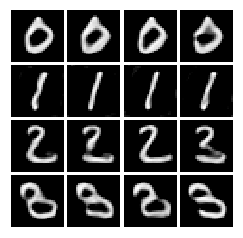

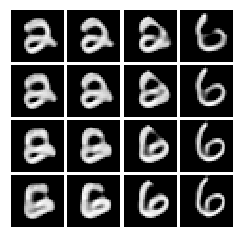

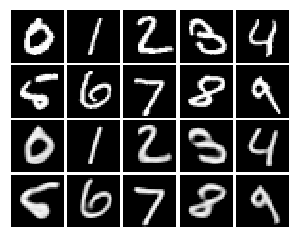


Iter: 264000, rencon_loss: 0.00745, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(510.0825, device='cuda:0')


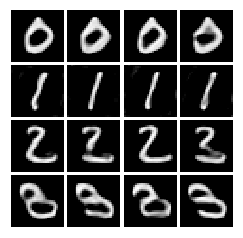

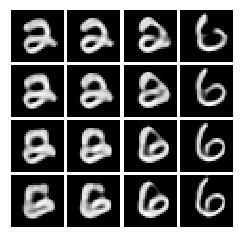

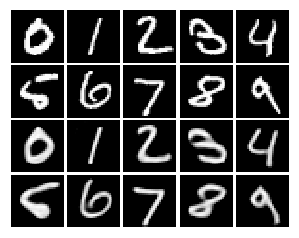


Iter: 267000, rencon_loss: 0.006102, adv_loss: 2.303, disent_loss:-2.272
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(509.1078, device='cuda:0')


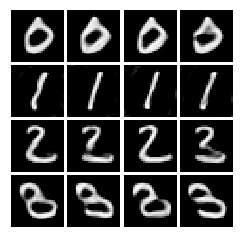

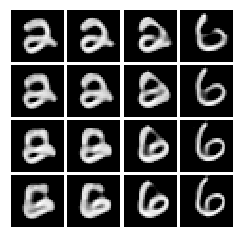

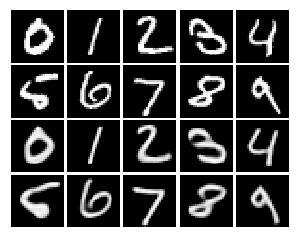


Iter: 270000, rencon_loss: 0.006222, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(502.9149, device='cuda:0')


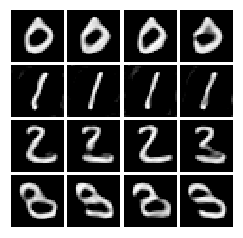

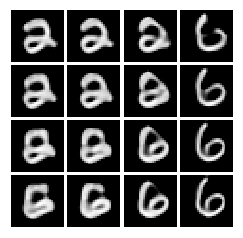

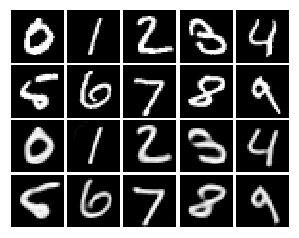


Iter: 273000, rencon_loss: 0.005707, adv_loss: 2.303, disent_loss:-2.274
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(521.9903, device='cuda:0')


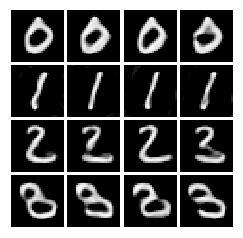

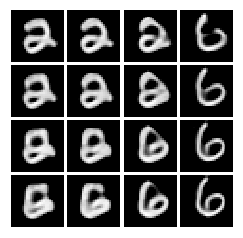

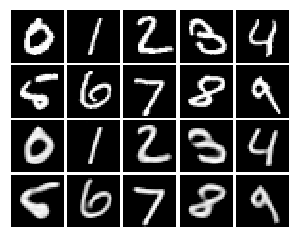


Iter: 276000, rencon_loss: 0.006473, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(519.2210, device='cuda:0')


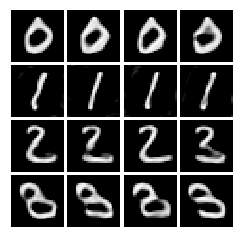

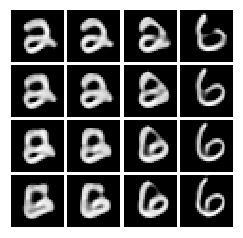

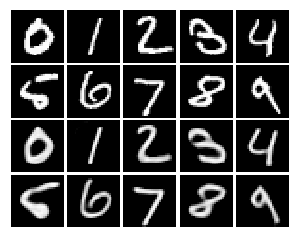


Iter: 279000, rencon_loss: 0.00721, adv_loss: 2.303, disent_loss:-2.267
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(509.7807, device='cuda:0')


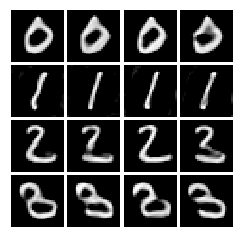

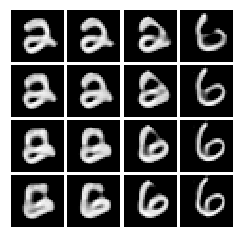

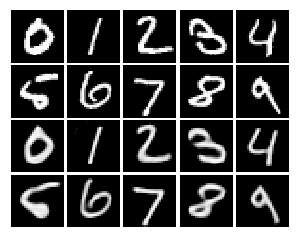


Iter: 282000, rencon_loss: 0.006807, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(511.4072, device='cuda:0')


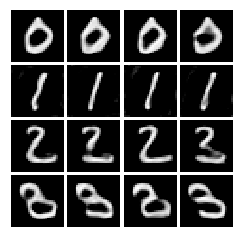

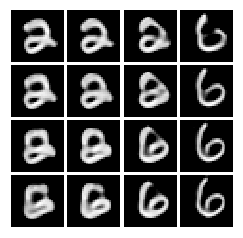

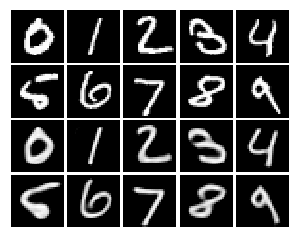


Iter: 285000, rencon_loss: 0.006738, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(523.2781, device='cuda:0')


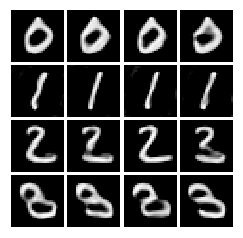

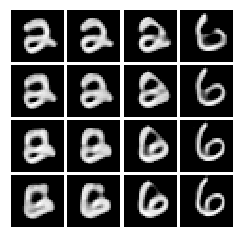

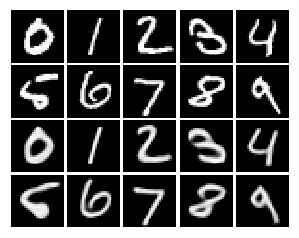


Iter: 288000, rencon_loss: 0.006767, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(516.9023, device='cuda:0')


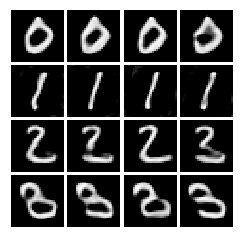

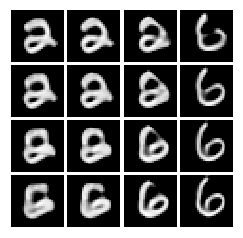

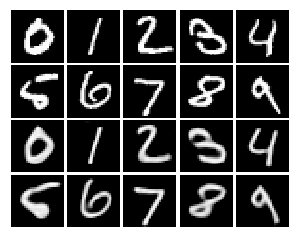


Iter: 291000, rencon_loss: 0.006627, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(529.1205, device='cuda:0')


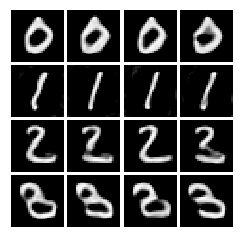

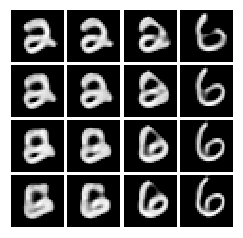

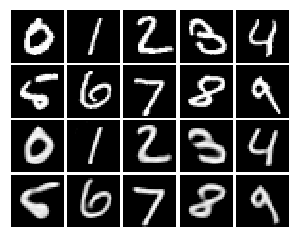


Iter: 294000, rencon_loss: 0.007371, adv_loss: 2.303, disent_loss:-2.266
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(500.8824, device='cuda:0')


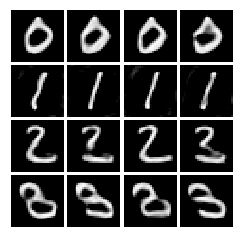

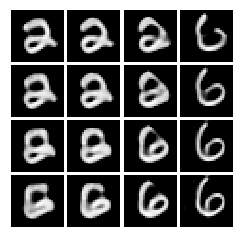

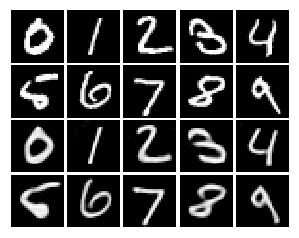


Iter: 297000, rencon_loss: 0.006383, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(517.7241, device='cuda:0')


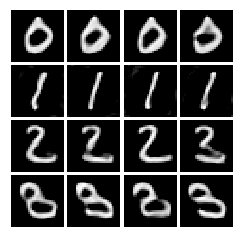

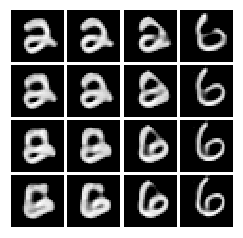

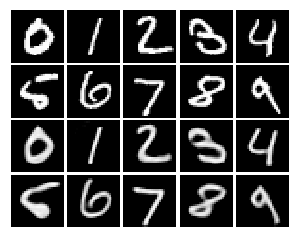


Iter: 300000, rencon_loss: 0.006706, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(541.6440, device='cuda:0')


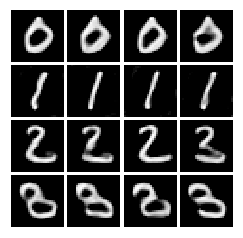

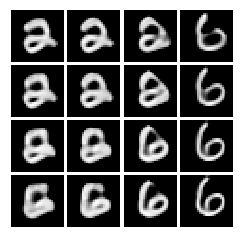

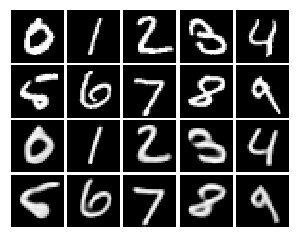


Iter: 303000, rencon_loss: 0.006518, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(548.7887, device='cuda:0')


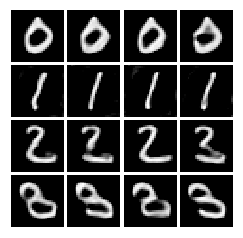

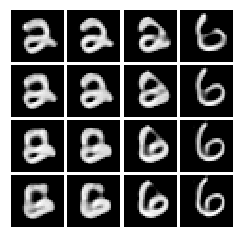

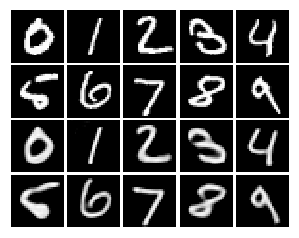


Iter: 306000, rencon_loss: 0.006278, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(521.1450, device='cuda:0')


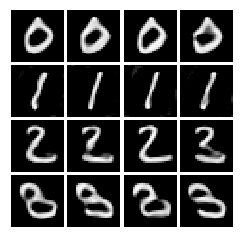

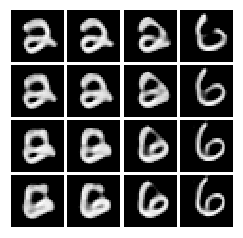

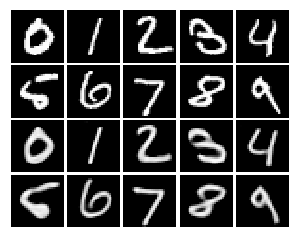


Iter: 309000, rencon_loss: 0.006381, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(557.5182, device='cuda:0')


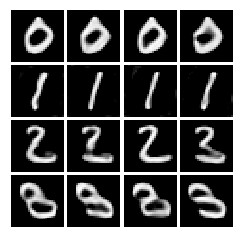

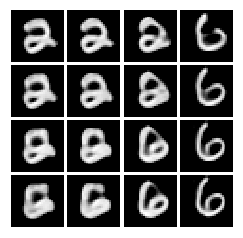

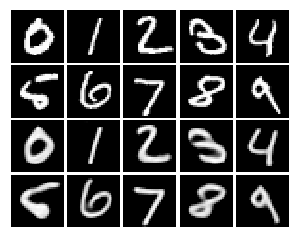


Iter: 312000, rencon_loss: 0.006706, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(544.6726, device='cuda:0')


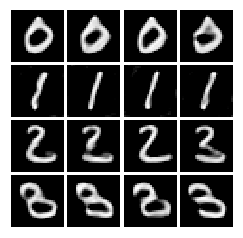

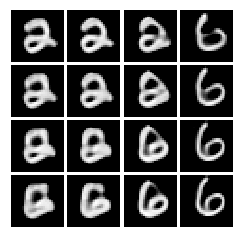

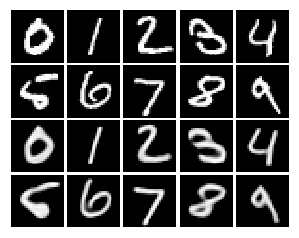


Iter: 315000, rencon_loss: 0.006441, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(512.7568, device='cuda:0')


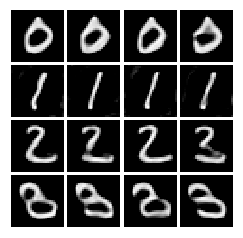

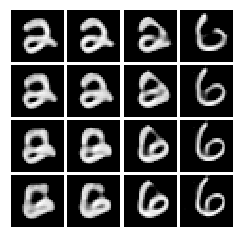

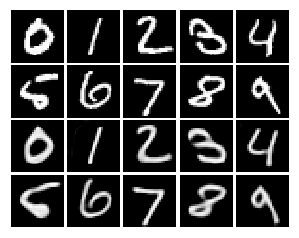


Iter: 318000, rencon_loss: 0.005057, adv_loss: 2.303, disent_loss:-2.277
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(535.8141, device='cuda:0')


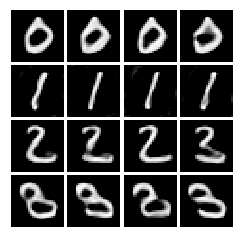

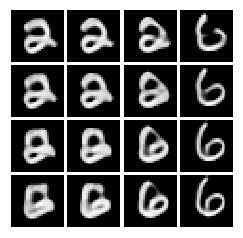

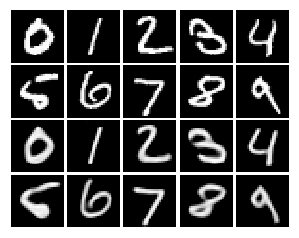


Iter: 321000, rencon_loss: 0.006806, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(544.6315, device='cuda:0')


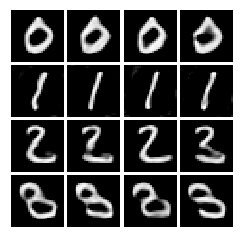

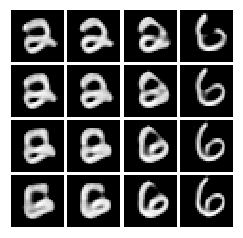

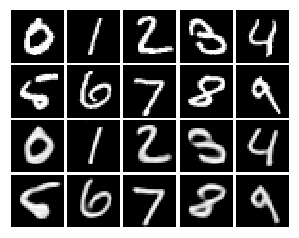


Iter: 324000, rencon_loss: 0.006408, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(547.7869, device='cuda:0')


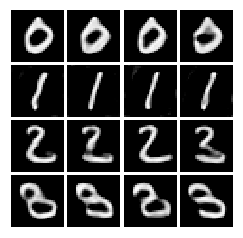

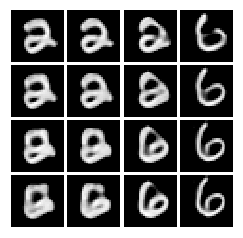

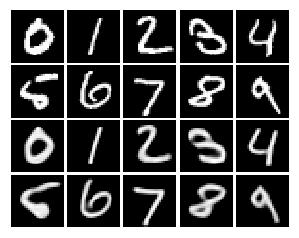


Iter: 327000, rencon_loss: 0.006337, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(541.8289, device='cuda:0')


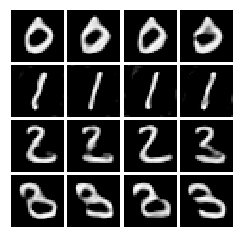

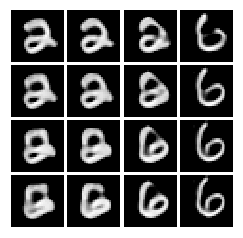

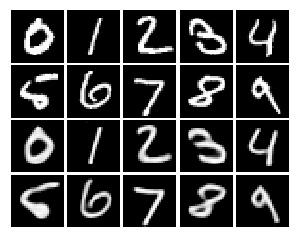


Iter: 330000, rencon_loss: 0.007479, adv_loss: 2.303, disent_loss:-2.265
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(536.9635, device='cuda:0')


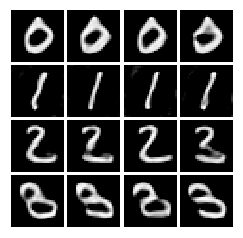

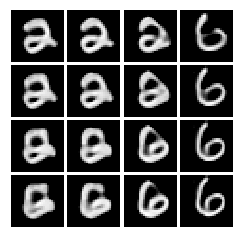

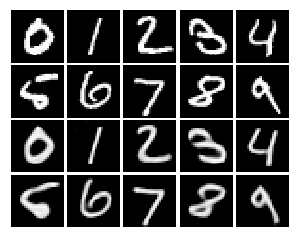


Iter: 333000, rencon_loss: 0.006623, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(544.0148, device='cuda:0')


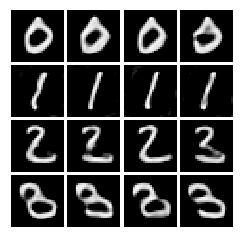

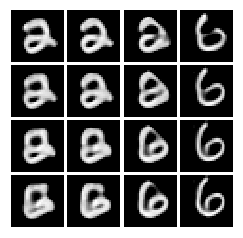

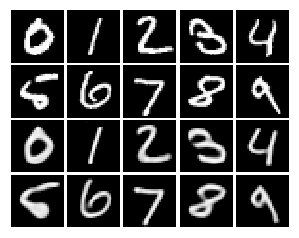


Iter: 336000, rencon_loss: 0.006892, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(534.2827, device='cuda:0')


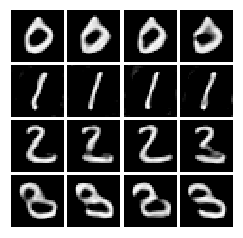

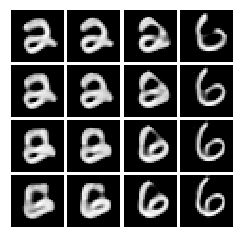

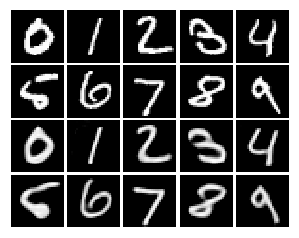


Iter: 339000, rencon_loss: 0.006278, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(548.1596, device='cuda:0')


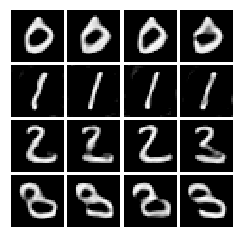

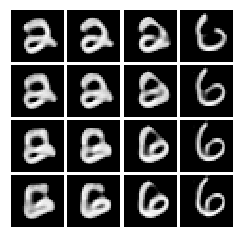

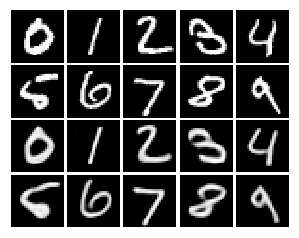


Iter: 342000, rencon_loss: 0.005867, adv_loss: 2.303, disent_loss:-2.273
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(563.0034, device='cuda:0')


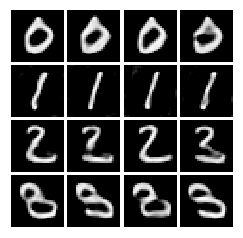

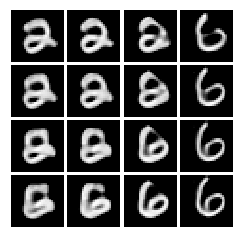

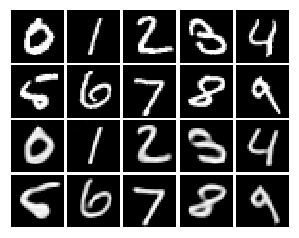


Iter: 345000, rencon_loss: 0.006296, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(546.9863, device='cuda:0')


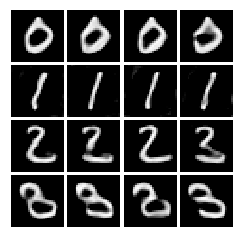

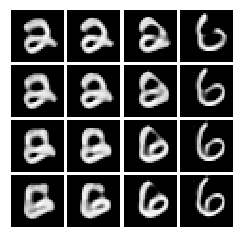

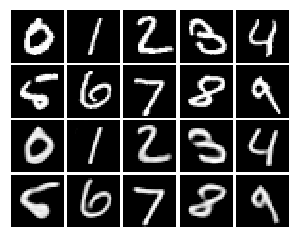


Iter: 348000, rencon_loss: 0.00693, adv_loss: 2.303, disent_loss:-2.268
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(576.9354, device='cuda:0')


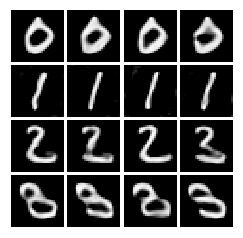

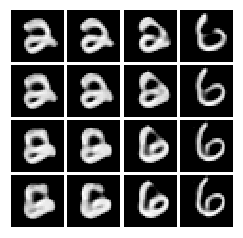

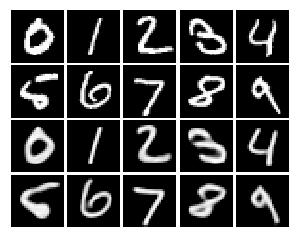


Iter: 351000, rencon_loss: 0.005664, adv_loss: 2.303, disent_loss:-2.274
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(574.4642, device='cuda:0')


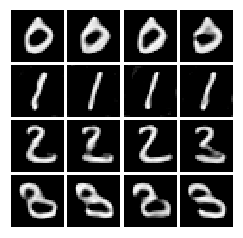

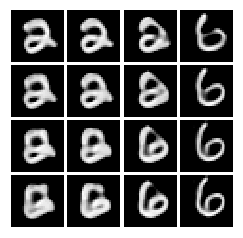

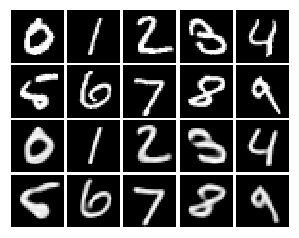


Iter: 354000, rencon_loss: 0.008546, adv_loss: 2.303, disent_loss:-2.26
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(554.8580, device='cuda:0')


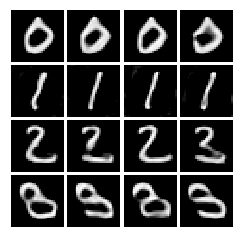

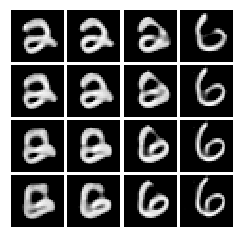

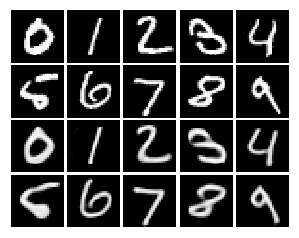


Iter: 357000, rencon_loss: 0.006462, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(573.8948, device='cuda:0')


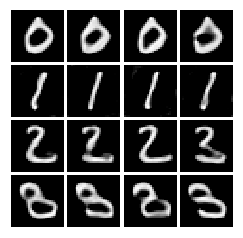

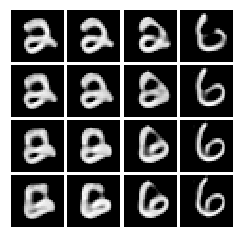

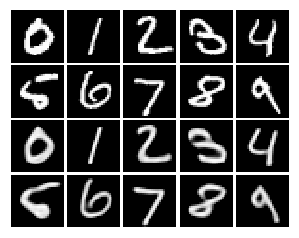


Iter: 360000, rencon_loss: 0.006285, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(534.8854, device='cuda:0')


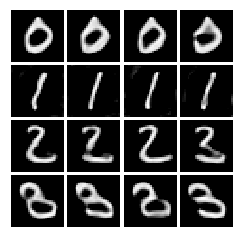

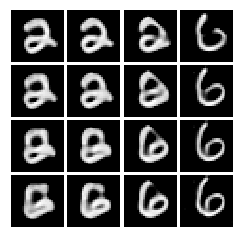

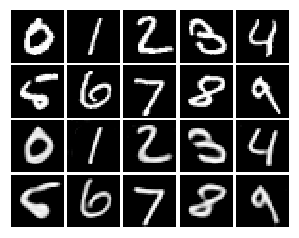


Iter: 363000, rencon_loss: 0.006739, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(568.2892, device='cuda:0')


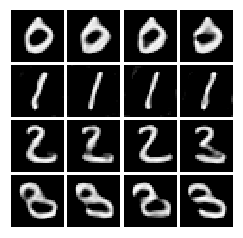

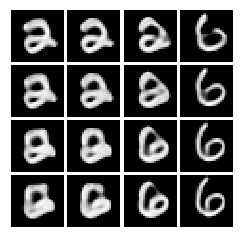

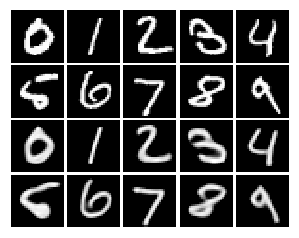


Iter: 366000, rencon_loss: 0.005688, adv_loss: 2.303, disent_loss:-2.274
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(555.4953, device='cuda:0')


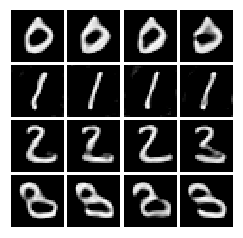

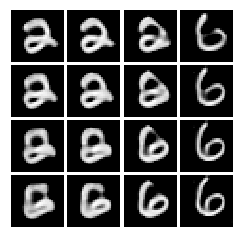

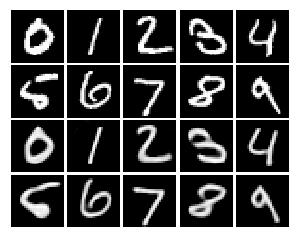


Iter: 369000, rencon_loss: 0.006416, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(579.5213, device='cuda:0')


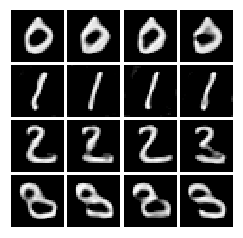

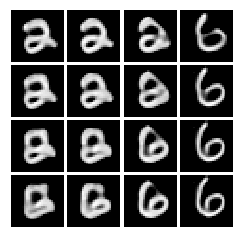

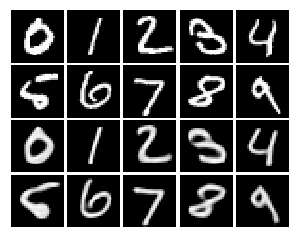


Iter: 372000, rencon_loss: 0.00604, adv_loss: 2.303, disent_loss:-2.272
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(568.3293, device='cuda:0')


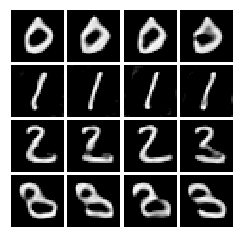

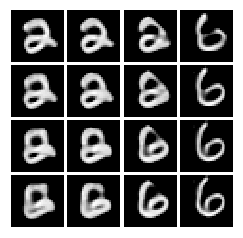

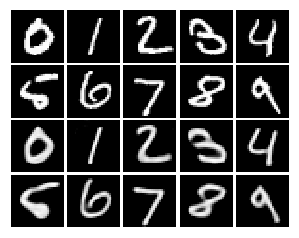


Iter: 375000, rencon_loss: 0.006365, adv_loss: 2.303, disent_loss:-2.271
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(567.9631, device='cuda:0')


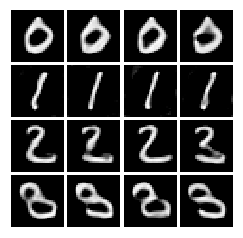

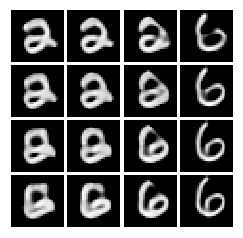

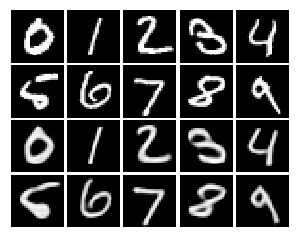


Iter: 378000, rencon_loss: 0.006636, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(563.0266, device='cuda:0')


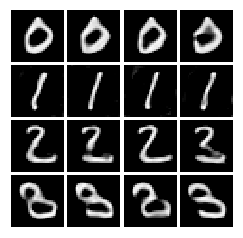

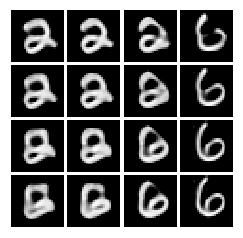

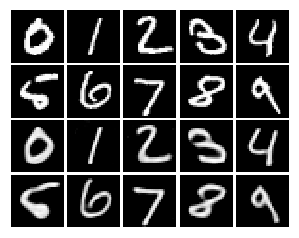


Iter: 381000, rencon_loss: 0.006706, adv_loss: 2.303, disent_loss:-2.269
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(564.8302, device='cuda:0')


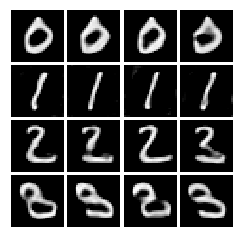

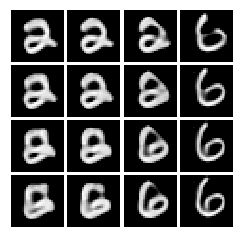

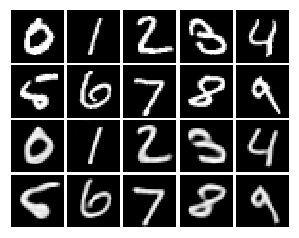


Iter: 384000, rencon_loss: 0.006431, adv_loss: 2.303, disent_loss:-2.27
adv classifier accuracy:
Checking accuracy on test set
Got 460 / 5000 correct (9.20)
z_latent_norm: tensor(572.8757, device='cuda:0')


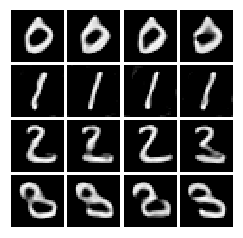

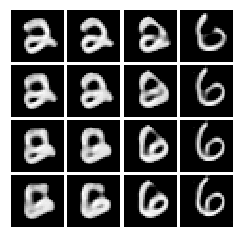

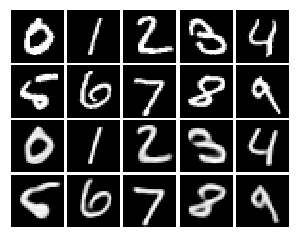

KeyboardInterrupt: 

In [116]:
dis_adv_solver.train(1000)
#train_DisAdvNet(s_enc, z_enc, sz_dec, z_adv,20)
#utils.save_models(save_list,var_save_path)

In [119]:
from copy import deepcopy
z_enc_back2 = deepcopy(z_enc)
z_adv_back2 = deepcopy(z_adv)
sz_dec_back2= deepcopy(sz_dec)
s_enc_back2 = deepcopy(s_enc)
back_save_lists = [z_enc_back,z_adv_back,sz_dec_back,s_enc_back]
utils.save_models(back_save_lists,path=save_path)

z_latent_norm: tensor(578.4373, device='cuda:0')


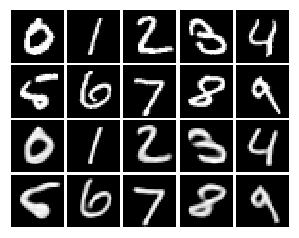

In [118]:
recon_net = layers.ReconNet(s_enc,z_enc,sz_dec)
solvers.test_recon(recon_net,dataloader)

In [97]:
def show_results(dis_adv_solver):
    dis_adv_solver.show_switch_latent()
    
    show_pairs = [((2,18),(6,10)),((1,25),(8,30)),((0,0),(1,0))]
    for pairs in show_pairs:
        dis_adv_solver.show_interpolated(10,tuples=pairs)

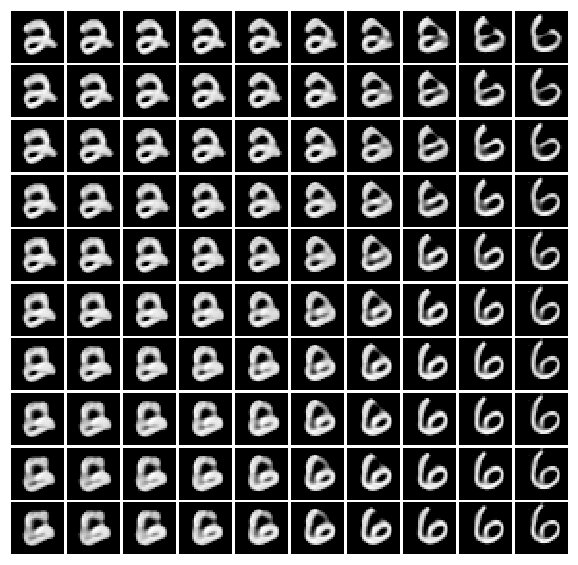

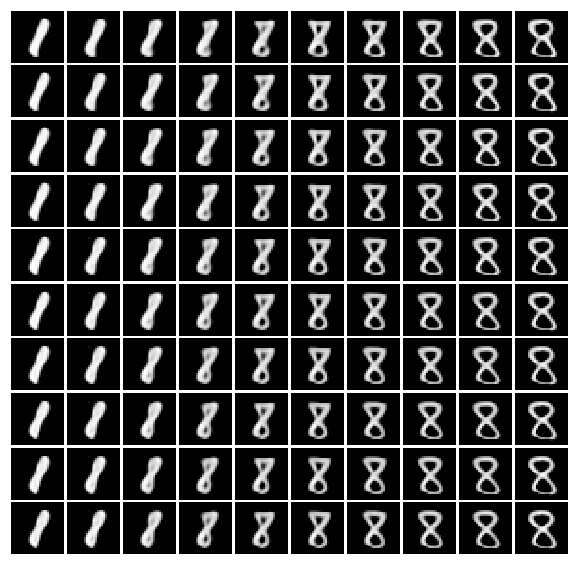

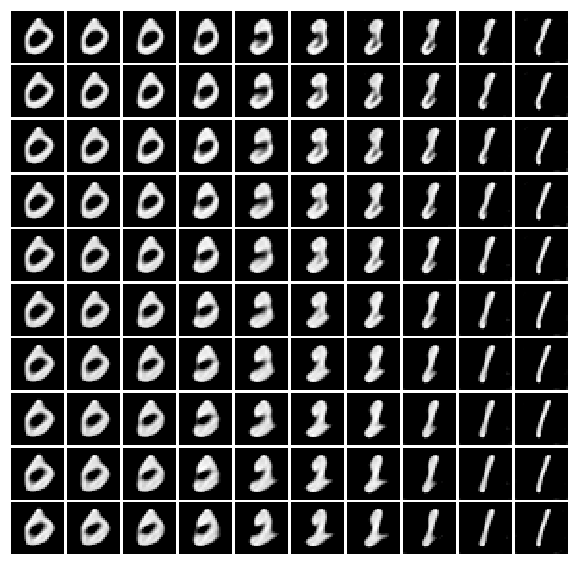

In [117]:
show_results(dis_adv_solver)

In [100]:
dis_adv_solver.show_switch_latent()

AttributeError: 'DisAdvSolver' object has no attribute 'show_switch_latent'

In [107]:
def show_switch_latent(self):
    s_latent=[]
    z_latent=[]
    img_lists = []
    s_enc = self.s_enc
    z_enc = self.z_enc
    sz_dec = self.sz_dec

    for classi in range(params.classes_num):
        img = self.dloader.img_grouped[classi][2].view(1,img_channel,img_size,img_size)
        img = img.to(device=device,dtype=dtype)
        
        s_latent.append( s_enc(img) )
        z_latent.append( z_enc(img) )
    for row in range(params.classes_num):
        for col in range(params.classes_num):
            latent = torch.cat((s_latent[col],z_latent[row]),dim=1)
            recon  = sz_dec(latent)
            img_lists.append(recon.view( img_size*img_size ) )

    utils.show_images(torch.stack(img_lists).detach().cpu().numpy())
dis_adv_solver.show_switch_latent()

AttributeError: 'DisAdvSolver' object has no attribute 'show_switch_latent'